# Combine Signals for Enhanced Alpha

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper`,`factor_pipelines` and `no_overlap_classifier`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions.

### Load Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.data.data_portal import DataPortal

import scripts.project_helper as project_helper
from scripts.risk_model import risk_modelling
from scripts.factors_pipeline import run_data_pipeline
from scripts.portfolio_optimizer import OptimalHoldingsStrictFactor
from scripts.no_overlap_classifier import NoOverlapVoter,non_overlapping_samples


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import alphalens as al
from alphalens.tears import create_full_tear_sheet

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

## Data Pipeline
### Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
universe = AverageDollarVolume(window_length=120).top(250) 
trading_calendar = get_calendar('XBOM') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

#### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using.

In [4]:
universe_end_date = pd.Timestamp('2020-05-15', tz='UTC')
factor_start_date = universe_end_date - pd.DateOffset(years=3,days=357)

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [3MINDIA]),
 Equity(1 [AARTIIND]),
 Equity(2 [AAVAS]),
 Equity(3 [ABBOTINDIA]),
 Equity(4 [ABCAPITAL]),
 Equity(5 [ABFRL]),
 Equity(7 [ADANIGAS]),
 Equity(8 [ADANIGREEN]),
 Equity(9 [ADANIPORTS]),
 Equity(10 [ADANIPOWER]),
 Equity(14 [AFFLE]),
 Equity(16 [AJANTPHARM]),
 Equity(18 [ALKEM]),
 Equity(20 [AMARAJABAT]),
 Equity(22 [AMBUJACEM]),
 Equity(24 [APLLTD]),
 Equity(25 [APOLLOHOSP]),
 Equity(26 [APOLLOTYRE]),
 Equity(30 [ASHOKLEY]),
 Equity(31 [ASIANPAINT]),
 Equity(33 [ASTRAL]),
 Equity(35 [ATUL]),
 Equity(36 [AUBANK]),
 Equity(37 [AUROPHARMA]),
 Equity(38 [AVANTIFEED]),
 Equity(39 [AXISBANK]),
 Equity(40 [BAJAJ-AUTO]),
 Equity(43 [BAJAJFINSV]),
 Equity(44 [BAJAJHLDNG]),
 Equity(45 [BAJFINANCE]),
 Equity(46 [BALKRISIND]),
 Equity(48 [BALRAMCHIN]),
 Equity(49 [BANDHANBNK]),
 Equity(50 [BANKBARODA]),
 Equity(51 [BANKINDIA]),
 Equity(53 [BATAINDIA]),
 Equity(57 [BEL]),
 Equity(58 [BEML]),
 Equity(59 [BERGEPAINT]),
 Equity(60 [BHARATFORG]),
 Equity(61 [BHARTIARTL]),
 Equity(6

### Get Returns
We have our pipeline built, let's access the returns data. We'll start by building a data portal.

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [5]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)


def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## Alpha Factors
It's time to start working on the alpha factors. In this project, we'll use the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor
- 15/30 Days RSI Of Returns
- RegressionAgainstTime to Compute Beta And Gamma

## Risk Factors
It's time to start working on the risk factors. In this project, we'll use the following factors:
- Sortino Ratio
- 3 Month Volatility

## Features and Labels
Let's create some features that we think will help the model make predictions.
### "Universal" Quant Features
To capture the universe, we'll use the following as features:
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

### Regime Features
We are going to try to capture market-wide regimes. To do that, we'll use the following features:
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

### Date Features
Let's make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

### Shift Target
We'll use shifted 5 day returns for training the model.

### Computing Factors Mentioned Above :-

In [6]:
all_factors = run_data_pipeline(engine,universe,factor_start_date,universe_end_date)

In [7]:
all_factors.head()

3 Month Volatility  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                  0.034523   
                          Equity(9 [ADANIPORTS])             0.030168   
                          Equity(10 [ADANIPOWER])            0.023631   
                          Equity(11 [ADANITRANS])            0.026619   
                          Equity(15 [AIAENG])                0.021278   

                                                   Downside Risk (Sortino Ratio)  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                             0.007969   
                          Equity(9 [ADANIPORTS])                       -0.119205   
                          Equity(10 [ADANIPOWER])                      -0.037865   
                          Equity(11 [ADANITRANS])                       0.040281   
                          Equity(15 [AIAENG])                          -0.065340   

                                                   Mean_Reversion_Sector_Neutral_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                                      0.414625   
                          Equity(9 [ADANIPORTS])                                 1.698626   
                          Equity(10 [ADANIPOWER])                                1.377626   
                          Equity(11 [ADANITRANS])                                1.618376   
                          Equity(15 [AIAENG])                                    0.267500   

                                                   Momentum_1YR  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])           -1.064193   
                          Equity(9 [ADANIPORTS])      -1.387121   
                          Equity(10 [ADANIPOWER])     -1.152264   
                          Equity(11 [ADANITRANS])           NaN   
                          Equity(15 [AIAENG])         -1.166943   

                                                   Overnight_Sentiment_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                           -0.394120   
                          Equity(9 [ADANIPORTS])                       1.438193   
                          Equity(10 [ADANIPOWER])                      1.216932   
                          Equity(11 [ADANITRANS])                      1.687111   
                          Equity(15 [AIAENG])                         -0.580809   

                                                   RSI_Sector_Neutral_15d  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                      0.719995   
                          Equity(9 [ADANIPORTS])                -1.698102   
                          Equity(10 [ADANIPOWER])               -0.719995   
                          Equity(11 [ADANITRANS])                0.584147   
                          Equity(15 [AIAENG])                   -0.815089   

                                                   RSI_Sector_Neutral_30d  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                      0.557446   
                          Equity(9 [ADANIPORTS])                -1.552885   
                          Equity(10 [ADANIPOWER])               -1.566157   
                          Equity(11 [ADANITRANS])               -0.968894   
                          Equity(15 [AIAENG])                   -0.875986   

                                                   adv_120d   adv_20d  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])       -0.672041 -1.364867   
                          Equity(9 [ADANIPORTS])   1.281728  1.503432   
                          Equity(10 [ADANIPOWER])  0.034641  0.270202   
                          Equity(11 [ADANITRANS]) -1.434150 -1.628141   
                          Equity(15 [AIAENG])     -1.489576 -1.641997   

                                                   conditional_factor   ...    \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                 -0.609159   ...     
                          Equity(9 [ADANIPORTS])             1.666013   ...     
                          Equity(10 [A

### Train/Valid/Test Splits
Now let's split the data into a train, validation, and test dataset. Implement the function `train_valid_test_split` to split the input samples, `all_x`, and targets values, `all_y` into a train, validation, and test dataset. The proportion sizes are `train_size`, `valid_size`, `test_size` respectively.

When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [8]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    train_end_index = int(len(all_x.index.levels[0].tolist())*train_size)
    valid_end_index = train_end_index + int(len(all_x.index.levels[0].tolist())*valid_size)
    test_end_index = valid_end_index + int(len(all_x.index.levels[0].tolist())*test_size)
    
    x_train,y_train = all_x.loc[all_x.index.levels[0].tolist()[:train_end_index]],all_y.loc[all_y.index.levels[0].tolist()[:train_end_index]]
    x_valid,y_valid = all_x.loc[all_x.index.levels[0].tolist()[train_end_index:valid_end_index]],all_y.loc[all_y.index.levels[0].tolist()[train_end_index:valid_end_index]]
    x_test,y_test = all_x.loc[all_x.index.levels[0].tolist()[valid_end_index:]],all_y.loc[all_y.index.levels[0].tolist()[valid_end_index:]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test


With `train_valid_test_split` implemented, let's split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [9]:
sector_columns= ['sector_SERVICES',
                 'sector_CEMENT & CEMENT PRODUCTS',
                 'sector_INDUSTRIAL MANUFACTURING',
                 'sector_METALS',
                 'sector_FINANCIAL SERVICES',
                 'sector_CHEMICALS',
                 'sector_PHARMA',
                 'sector_OIL & GAS',
                 'sector_POWER',
                 'sector_CONSUMER GOODS',
                 'sector_IT',
                 'sector_AUTOMOBILE',
                 'sector_HEALTHCARE SERVICES',
                 'sector_CONSTRUCTION',
                 'sector_FERTILISERS & PESTICIDES',
                 'sector_TELECOM',
                 'sector_MEDIA & ENTERTAINMENT',
                 'sector_TEXTILES',
                 'sector_PAPER']

features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'RSI_Sector_Neutral_15d','RSI_Sector_Neutral_30d',
    '3 Month Volatility','Downside Risk (Sortino Ratio)',
    'time_beta','time_gamma','conditional_factor',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_March', 'is_April', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns

target_label = 'target'

temp = all_factors.copy()
temp = temp.fillna(0)
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                                      0.414625   
                          Equity(9 [ADANIPORTS])                                 1.698626   
                          Equity(10 [ADANIPOWER])                                1.377626   
                          Equity(11 [ADANITRANS])                                1.618376   
                          Equity(15 [AIAENG])                                    0.267500   

                                                   Momentum_1YR  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])           -1.064193   
                          Equity(9 [ADANIPORTS])      -1.387121   
                          Equity(10 [ADANIPOWER])     -1.152264   
                          Equity(11 [ADANITRANS])      0.000000   
                          Equity(15 [AIAENG])         -1.166943   

                                                   RSI_Sector_Neutral_15d  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                      0.719995   
                          Equity(9 [ADANIPORTS])                -1.698102   
                          Equity(10 [ADANIPOWER])               -0.719995   
                          Equity(11 [ADANITRANS])                0.584147   
                          Equity(15 [AIAENG])                   -0.815089   

                                                   RSI_Sector_Neutral_30d  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                      0.557446   
                          Equity(9 [ADANIPORTS])                -1.552885   
                          Equity(10 [ADANIPOWER])               -1.566157   
                          Equity(11 [ADANITRANS])               -0.968894   
                          Equity(15 [AIAENG])                   -0.875986   

                                                   3 Month Volatility  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                  0.034523   
                          Equity(9 [ADANIPORTS])             0.030168   
                          Equity(10 [ADANIPOWER])            0.023631   
                          Equity(11 [ADANITRANS])            0.026619   
                          Equity(15 [AIAENG])                0.021278   

                                                   Downside Risk (Sortino Ratio)  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                             0.007969   
                          Equity(9 [ADANIPORTS])                       -0.119205   
                          Equity(10 [ADANIPOWER])                      -0.037865   
                          Equity(11 [ADANITRANS])                       0.040281   
                          Equity(15 [AIAENG])                          -0.065340   

                                                   time_beta  time_gamma  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])         1.078872   -1.166943   
                          Equity(9 [ADANIPORTS])   -0.770623   -0.741266   
                          Equity(10 [ADANIPOWER])  -0.315588    0.506409   
                          Equity(11 [ADANITRANS])   0.000000    0.000000   
                          Equity(15 [AIAENG])      -1.533906    1.519228   

                                                   conditional_factor  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                 -0.609159   
                          Equity(9 [ADANIPORTS])             1.666013   
                          Equity(10 [ADANIPOWER])            0.697230   
                          Equity(11 [ADANITRANS])            0.000000   
                          Equity(15 [AIAENG])               -1.357764   

                                                   Overnight_Sentiment_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(5 [ABFRL])                           -0.394120   
                          Equity(9 [ADANIPORTS])                       1.438193   
                          Equity(10 [ADANIPOWER])                      1.2

In [10]:
i = 1
print('Features :')
for value in X_train.columns.values:
    print('{}. {}'.format(i,value))
    i += 1

Features :
1. Mean_Reversion_Sector_Neutral_Smoothed
2. Momentum_1YR
3. RSI_Sector_Neutral_15d
4. RSI_Sector_Neutral_30d
5. 3 Month Volatility
6. Downside Risk (Sortino Ratio)
7. time_beta
8. time_gamma
9. conditional_factor
10. Overnight_Sentiment_Smoothed
11. adv_120d
12. adv_20d
13. dispersion_120d
14. dispersion_20d
15. market_vol_120d
16. market_vol_20d
17. volatility_20d
18. is_March
19. is_April
20. weekday
21. month_end
22. month_start
23. qtr_end
24. qtr_start
25. sector_SERVICES
26. sector_CEMENT & CEMENT PRODUCTS
27. sector_INDUSTRIAL MANUFACTURING
28. sector_METALS
29. sector_FINANCIAL SERVICES
30. sector_CHEMICALS
31. sector_PHARMA
32. sector_OIL & GAS
33. sector_POWER
34. sector_CONSUMER GOODS
35. sector_IT
36. sector_AUTOMOBILE
37. sector_HEALTHCARE SERVICES
38. sector_CONSTRUCTION
39. sector_FERTILISERS & PESTICIDES
40. sector_TELECOM
41. sector_MEDIA & ENTERTAINMENT
42. sector_TEXTILES
43. sector_PAPER


### Factor Names To Compare Against AI Alpha
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [11]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'time_beta',
    'time_gamma']

### Model Results
Let's look at some additional metrics to see how well a model performs. We've created the function `show_sample_results` to show the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation
- Information Tear Sheet
- Returns Tear Sheet

In [12]:
all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(data_portal,trading_calendar,all_assets,factor_start_date,universe_end_date)

In [13]:
def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_Alpha'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n--------------------------------------------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    print('             AI ALPHA :-')
    create_full_tear_sheet(factor_data['AI_Alpha'])
    print('\n--------------------------------------------------------\n')
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)


# Modelling And Evaluation

## Random Forests
### Checking a Simple Tree
Let's see how a single tree would look using our data.

In [14]:
# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)

simple_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [15]:
n_days = 10
n_stocks = 250

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}

n_trees_l = [50, 100, 250, 500, 1000]

We’ll choose a min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.  We can first propose 500, which is the number of assets in the estimation universe. Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative.  It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. If we were to try these values, we’d notice that the model is “too good to be true” on the training data.  A good rule of thumb for what is considered “too good to be true”, and therefore a sign of overfitting, is if the sharpe ratio is greater than 4.  Based on this, we recommend using min_sampes_leaf of 10 * 500, or 5,000.

Feel free to try other values for these parameters, but also keep in mind that making too many small adjustments to hyper-parameters can lead to overfitting even the validation data, and therefore lead to less generalizable performance on the out-of-sample test set.  So when trying different parameter values, choose values that are different enough in scale (i.e. 10, 20, 100 instead of 10,11,12).

In [16]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [03:33<00:00, 42.76s/Model]


Let's look at the accuracy of the classifiers over the number of trees.

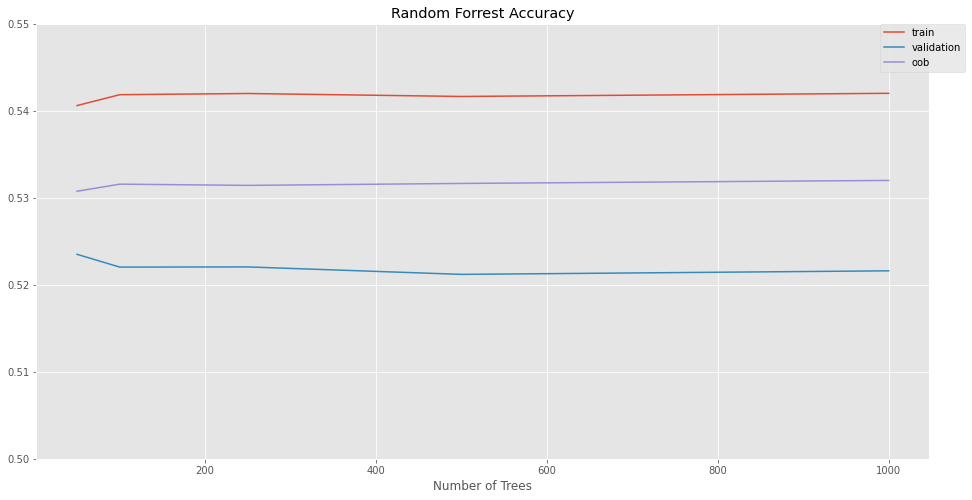

In [17]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

##### Training Prediction
Let's see how well the model runs on training data.

Cleaning Data...

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.085152 -0.017673 -0.039513  0.010638  29350     20.0
2               -0.045335 -0.002997 -0.021400  0.006845  29350     20.0
3               -0.026883  0.013190 -0.006601  0.006080  29350     20.0
4               -0.008534  0.038136  0.011022  0.008000  29350     20.0
5                0.004655  0.099664  0.039266  0.015845  29350     20.0

Returns Analysis


1D
Ann. alpha                                      0.312
beta                                           -0.195
Mean Period Wise Return Top Quantile (bps)      8.112
Mean Period Wise Return Bottom Quantile (bps) -15.562
Mean Period Wise Spread (bps)                  23.675

<Figure size 1152x576 with 0 Axes>

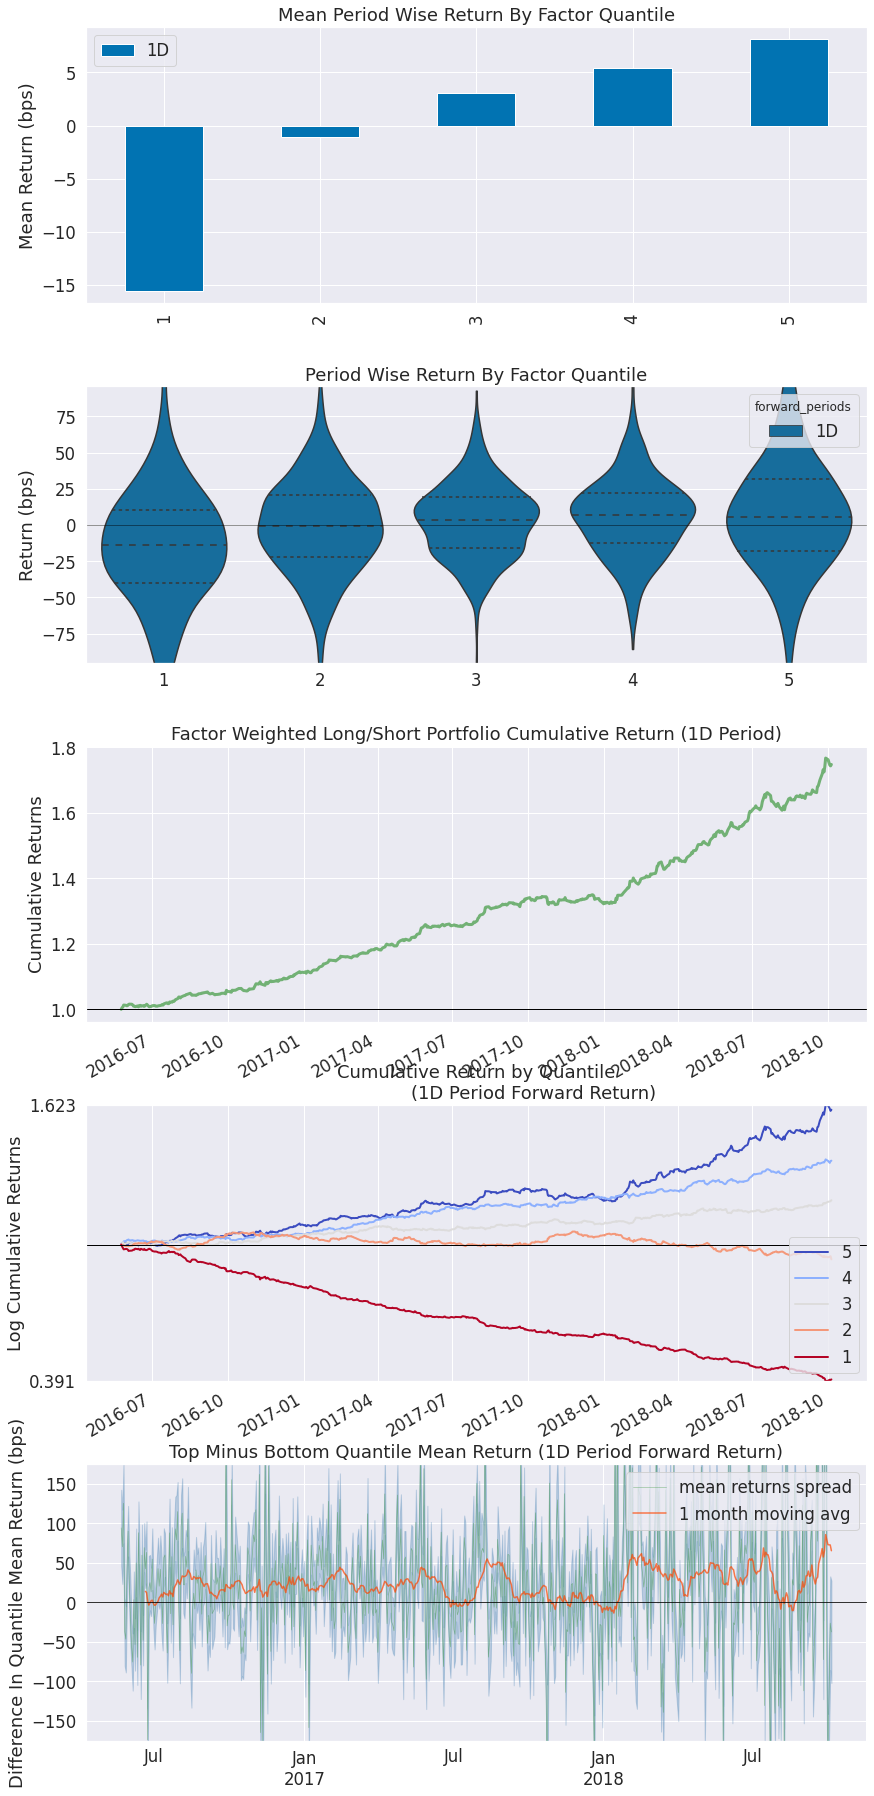

Information Analysis


1D
IC Mean            0.067
IC Std.            0.137
Risk-Adjusted IC   0.485
t-stat(IC)        11.761
p-value(IC)        0.000
IC Skew            0.118
IC Kurtosis        0.121

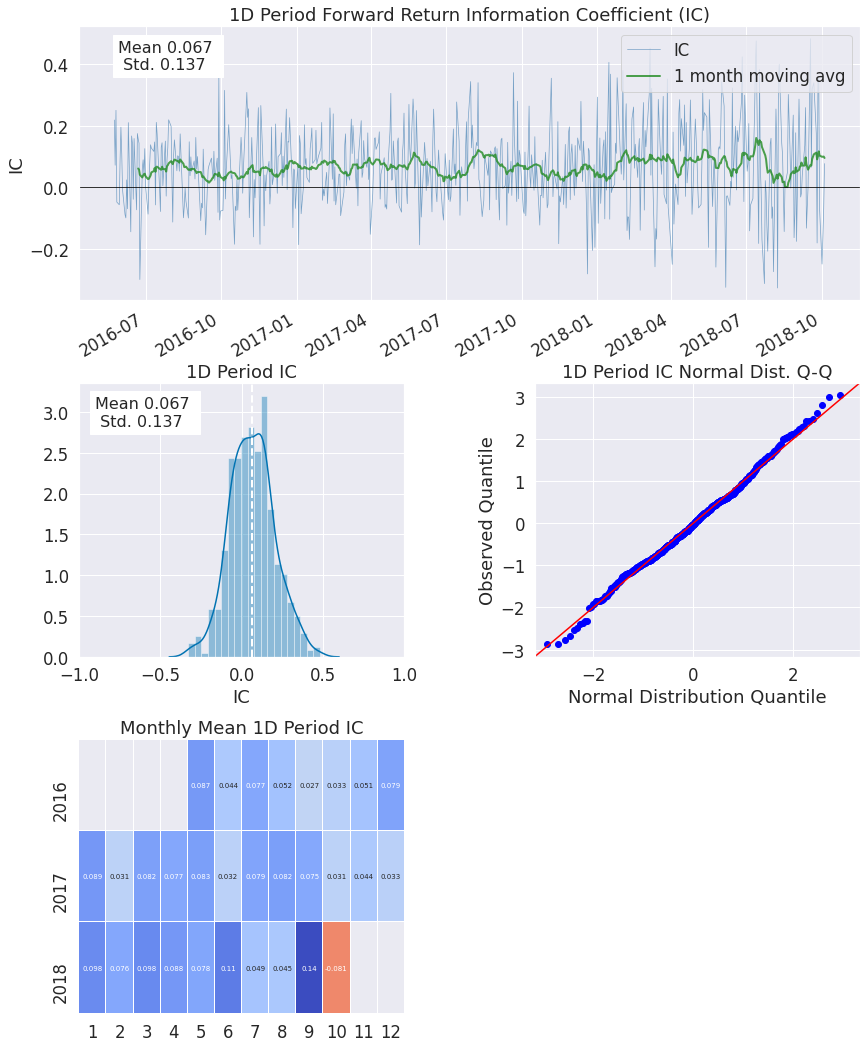

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.133
Quantile 2 Mean Turnover   0.268
Quantile 3 Mean Turnover   0.273
Quantile 4 Mean Turnover   0.219
Quantile 5 Mean Turnover   0.089

1D
Mean Factor Rank Autocorrelation  0.972

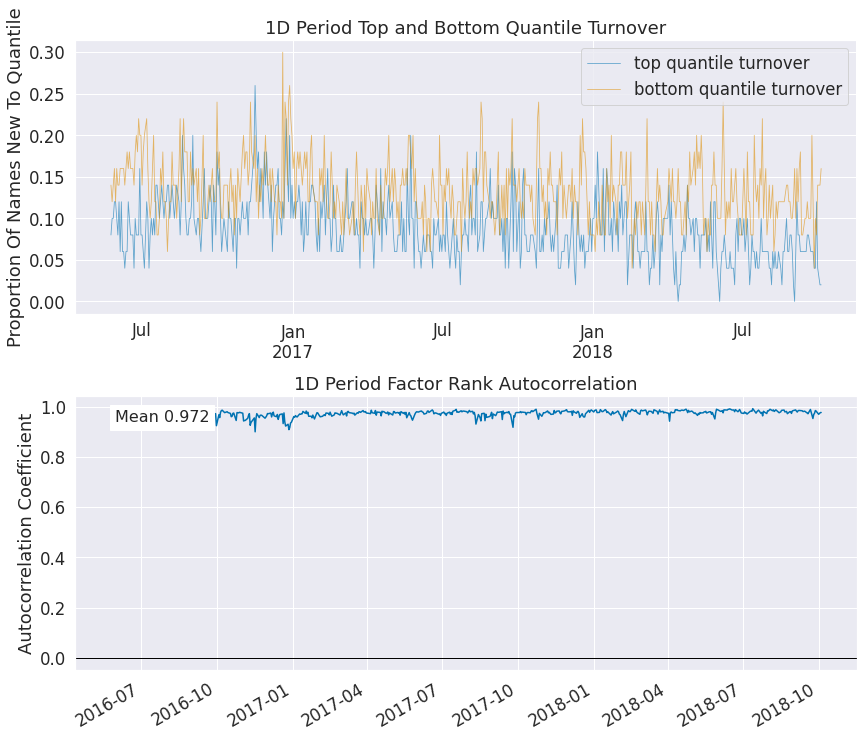


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    0.77
Momentum_1YR                              1.20
Overnight_Sentiment_Smoothed              0.35
time_beta                                 0.47
time_gamma                                0.36
AI_Alpha                                  4.59
dtype: float64


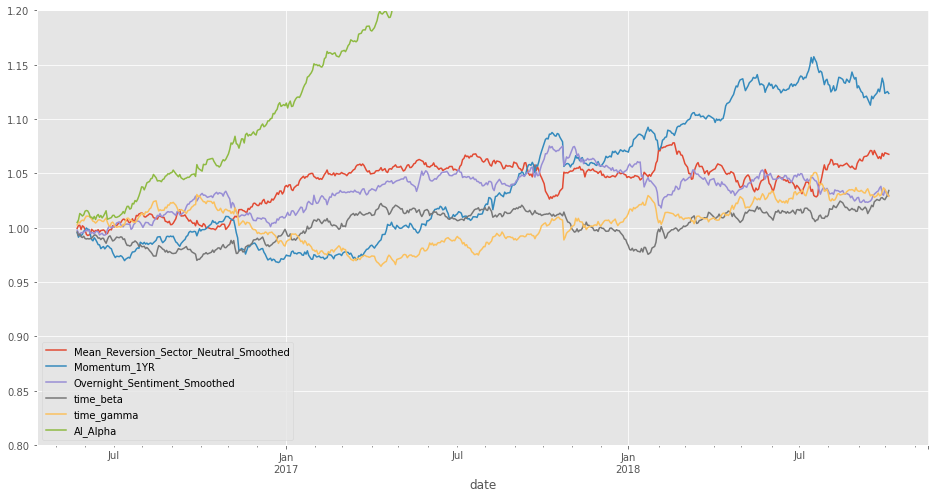

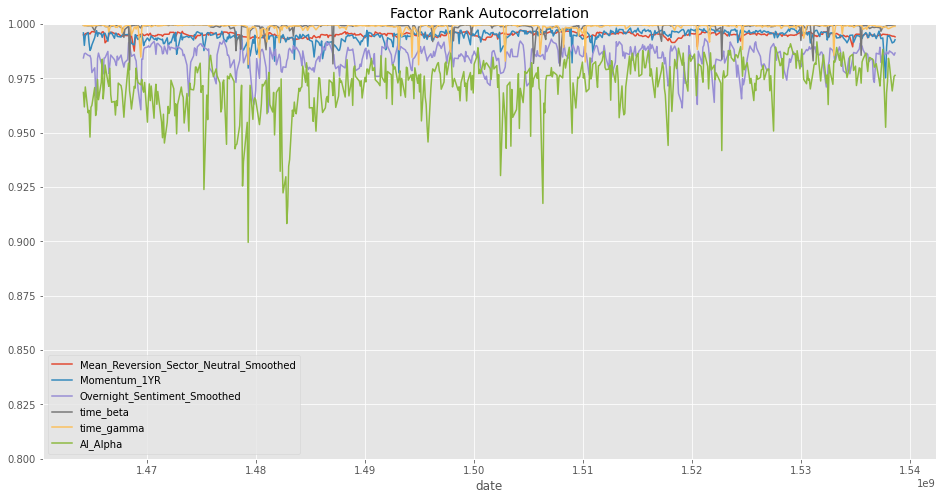

In [18]:
show_sample_results(all_factors, X_train, clf, factor_names)

##### Validation Prediction
Let's see how well the model runs on validation data.

Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.079808 -0.024508 -0.044263  0.009436   9800     20.0
2               -0.044973 -0.012246 -0.026278  0.005584   9800     20.0
3               -0.026254  0.001934 -0.011948  0.005133   9800     20.0
4               -0.011074  0.026833  0.004786  0.007628   9800     20.0
5                0.002316  0.089342  0.032161  0.015978   9800     20.0

Returns Analysis


1D
Ann. alpha                                     0.089
beta                                          -0.352
Mean Period Wise Return Top Quantile (bps)     2.358
Mean Period Wise Return Bottom Quantile (bps) -5.639
Mean Period Wise Spread (bps)                  7.997

<Figure size 1152x576 with 0 Axes>

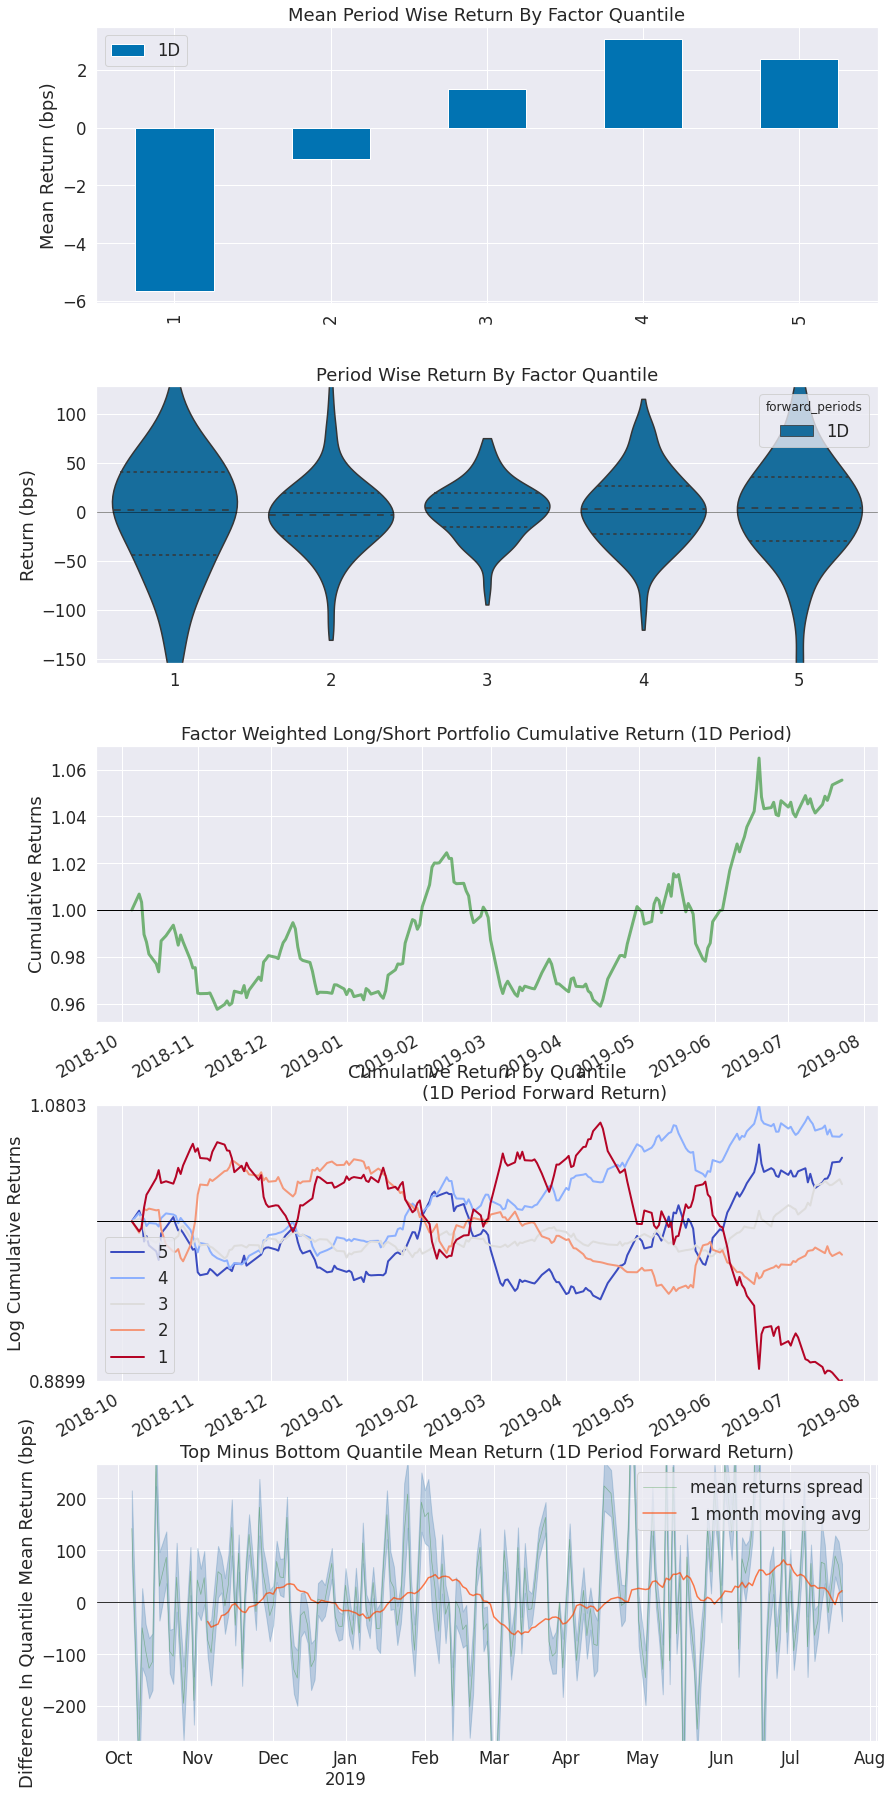

Information Analysis


1D
IC Mean           0.043
IC Std.           0.182
Risk-Adjusted IC  0.236
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

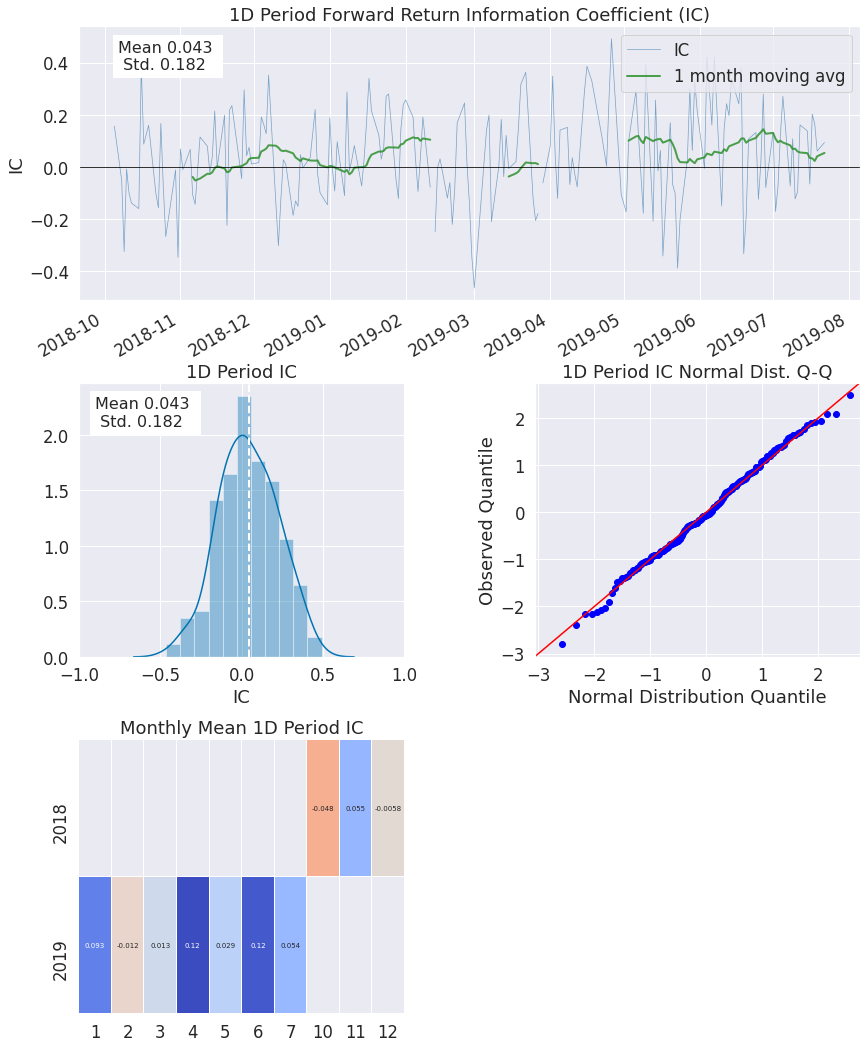

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.117
Quantile 2 Mean Turnover   0.243
Quantile 3 Mean Turnover   0.260
Quantile 4 Mean Turnover   0.218
Quantile 5 Mean Turnover   0.088

1D
Mean Factor Rank Autocorrelation  0.976

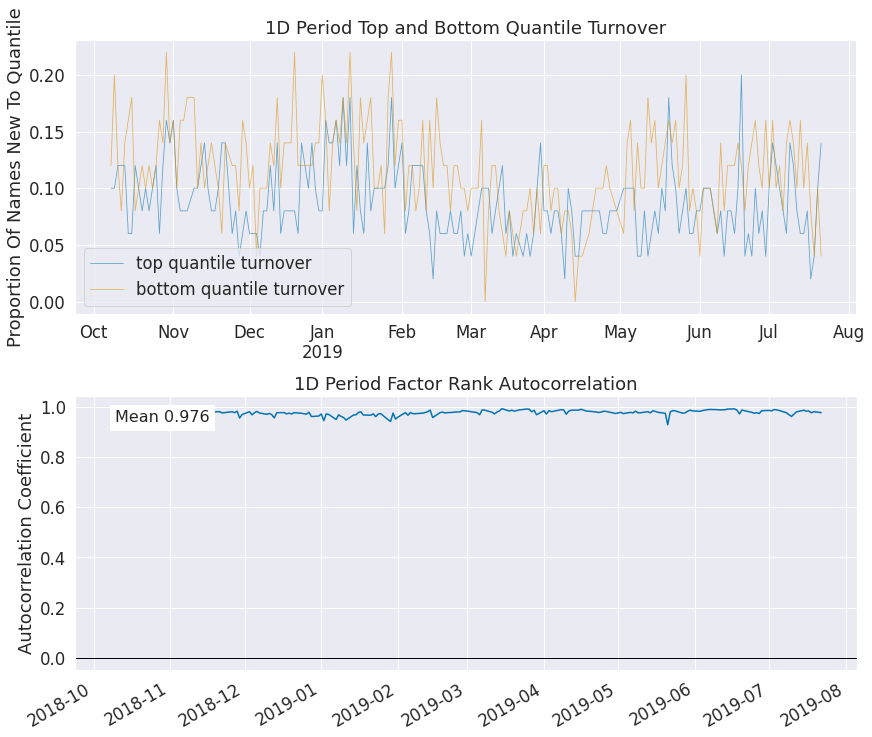


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    1.64
Momentum_1YR                              0.92
Overnight_Sentiment_Smoothed             -2.88
time_beta                                -1.27
time_gamma                                2.20
AI_Alpha                                  0.88
dtype: float64


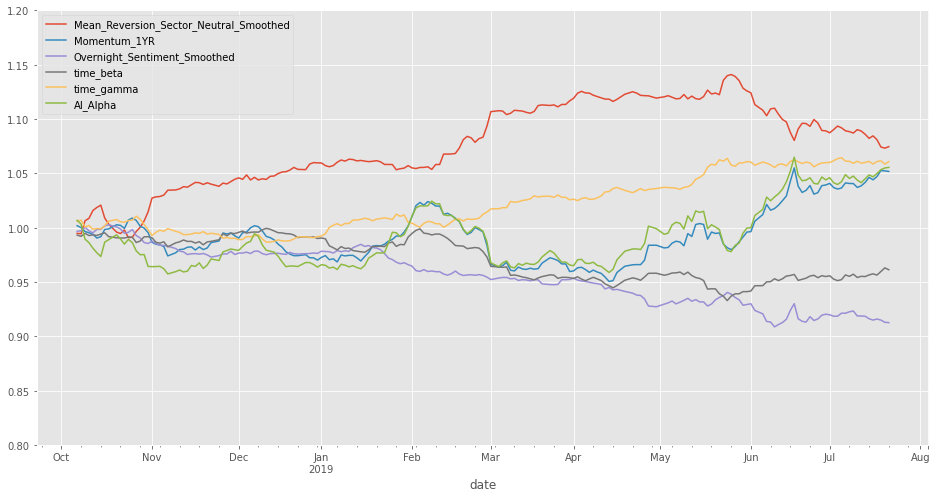

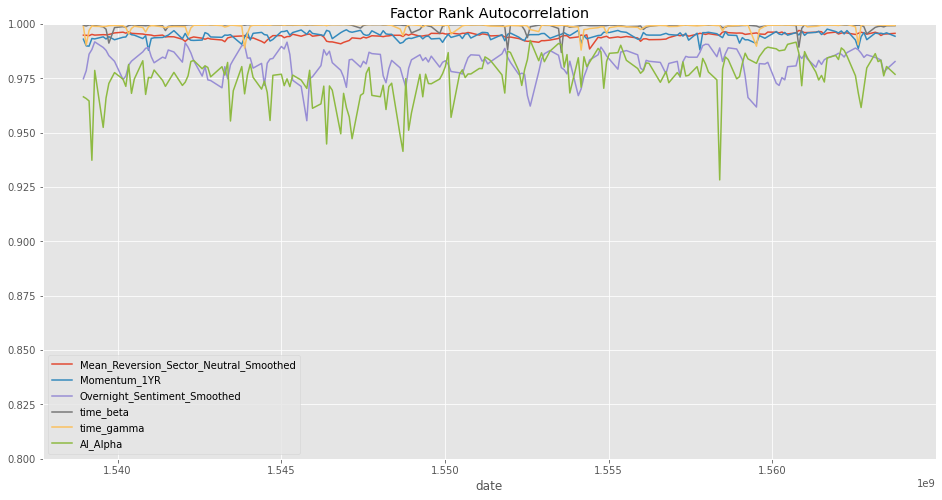

In [19]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Build an ensemble of non-overlapping trees

In this project, we'll do all two methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [20]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [00:38<00:00,  7.70s/Model]


#### Results

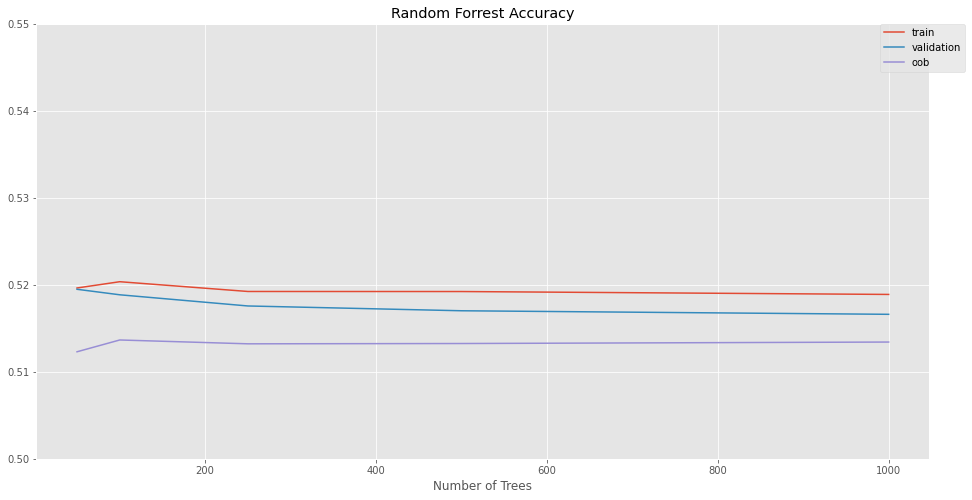

In [21]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.052024 -0.024376 -0.034384  0.004703   9800     20.0
2               -0.031470 -0.012304 -0.021938  0.003870   9800     20.0
3               -0.020976 -0.000873 -0.011069  0.003972   9800     20.0
4               -0.011309  0.014159  0.000614  0.004824   9800     20.0
5                0.001866  0.047935  0.020107  0.009374   9800     20.0

Returns Analysis


1D
Ann. alpha                                     0.051
beta                                          -0.342
Mean Period Wise Return Top Quantile (bps)     2.139
Mean Period Wise Return Bottom Quantile (bps) -2.526
Mean Period Wise Spread (bps)                  4.665

<Figure size 1152x576 with 0 Axes>

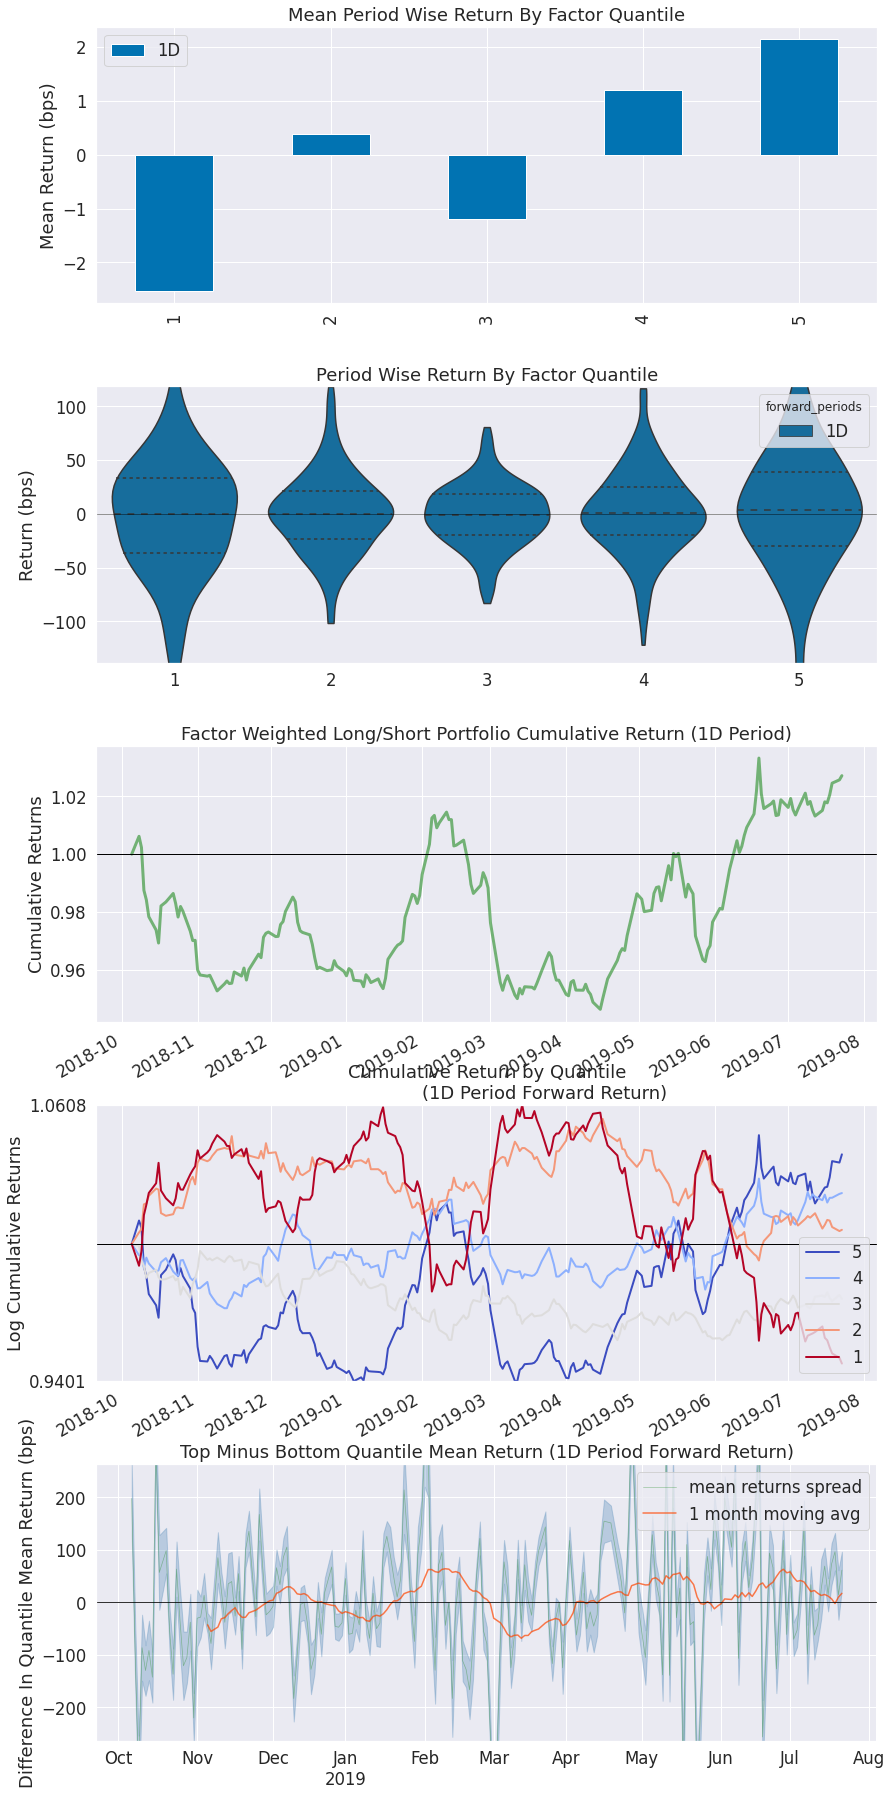

Information Analysis


1D
IC Mean           0.037
IC Std.           0.184
Risk-Adjusted IC  0.202
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

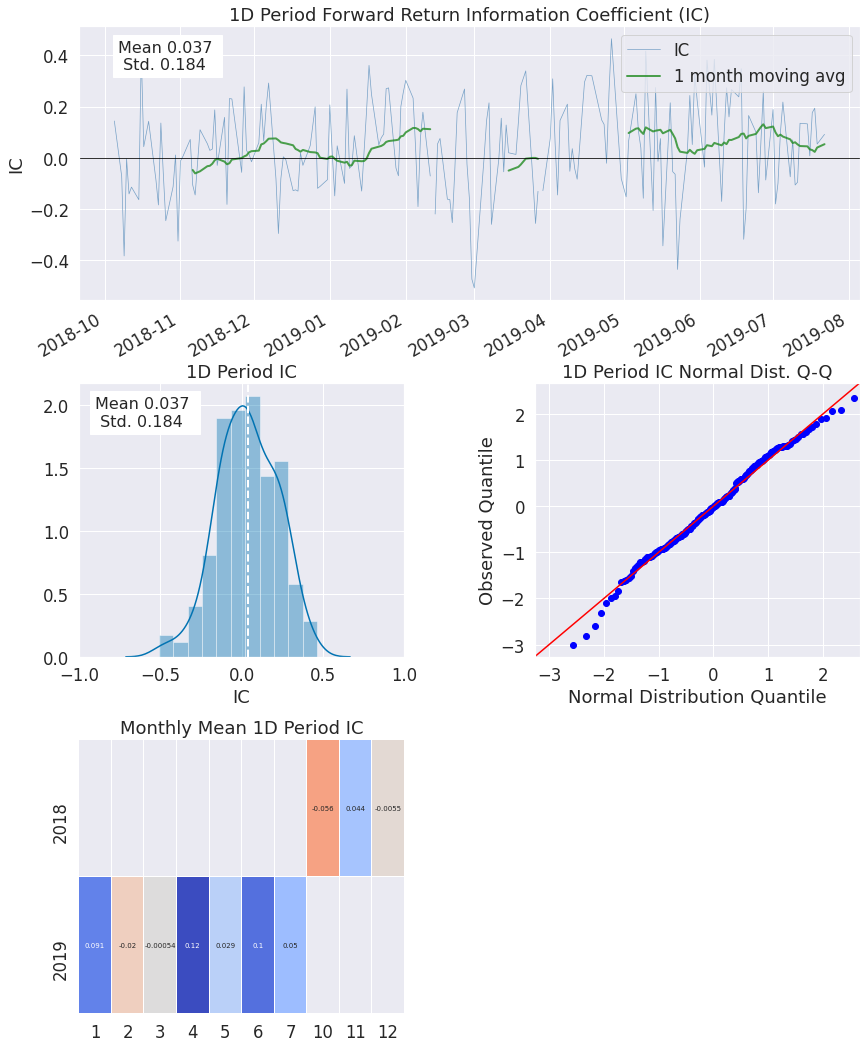

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.097
Quantile 2 Mean Turnover   0.206
Quantile 3 Mean Turnover   0.222
Quantile 4 Mean Turnover   0.179
Quantile 5 Mean Turnover   0.065

1D
Mean Factor Rank Autocorrelation  0.981

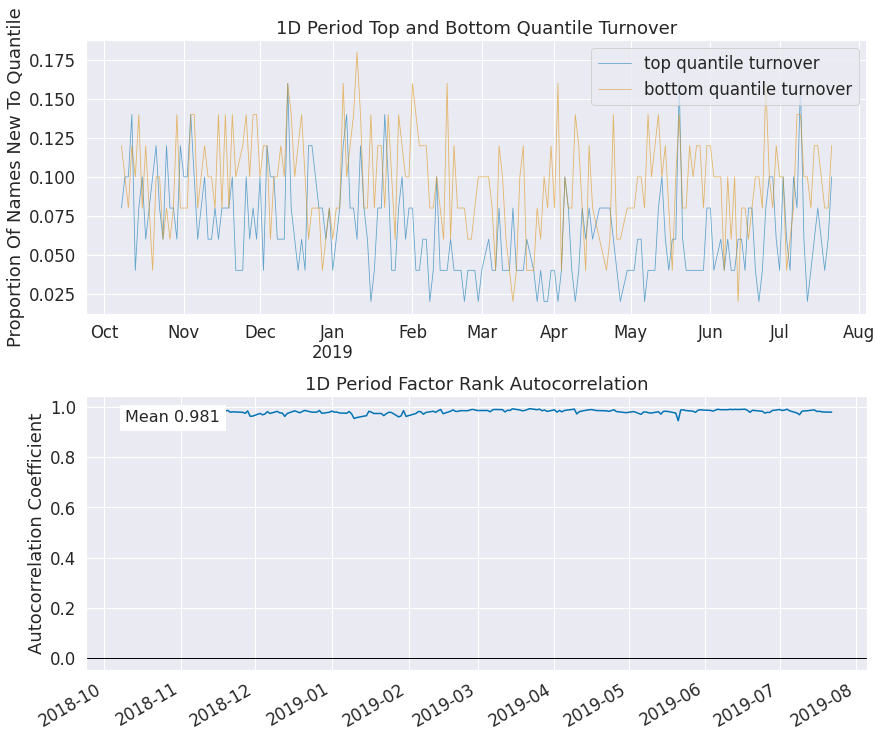


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    1.64
Momentum_1YR                              0.92
Overnight_Sentiment_Smoothed             -2.88
time_beta                                -1.27
time_gamma                                2.20
AI_Alpha                                  0.47
dtype: float64


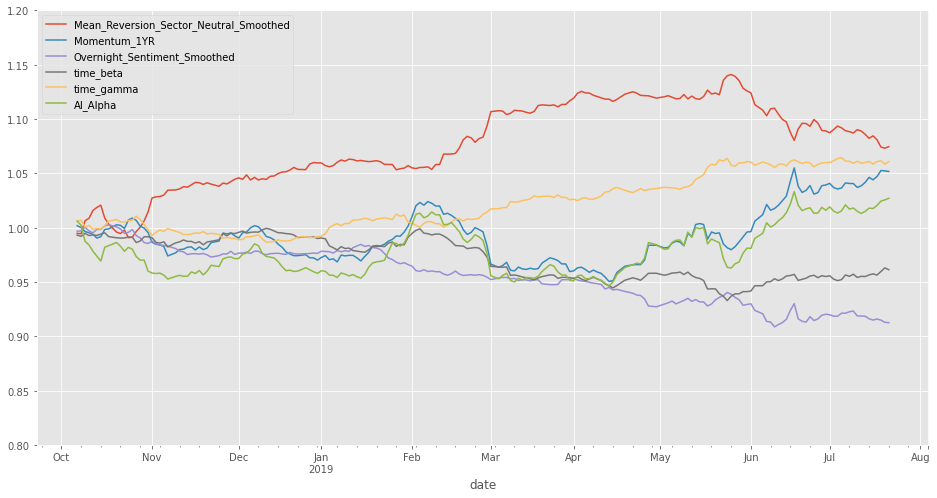

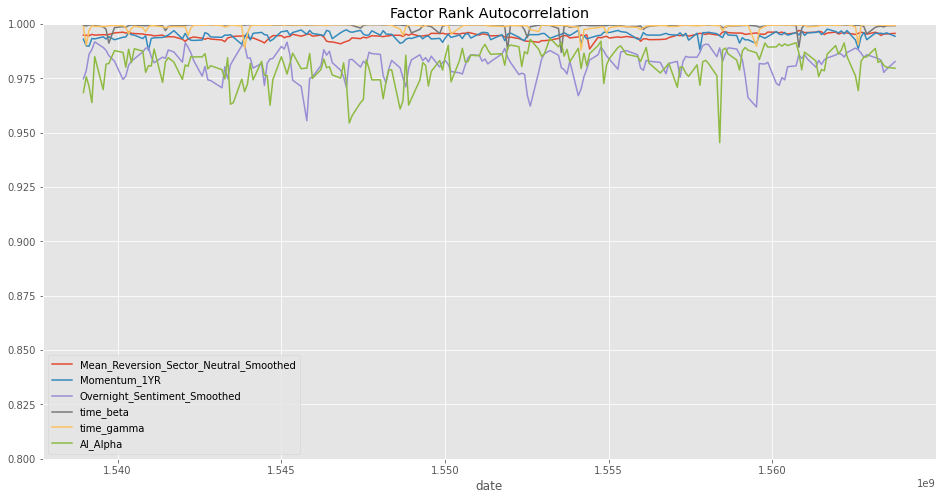

In [22]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [23]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|██████████| 5/5 [02:53<00:00, 34.64s/Model]


#### Results

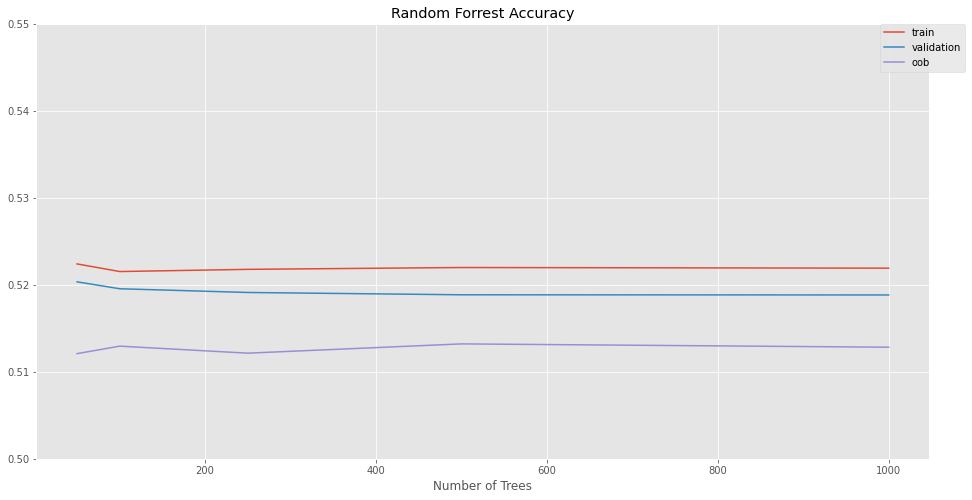

In [24]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

#### Train :

Cleaning Data...

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.043171 -0.011453 -0.023717  0.005510  29350     20.0
2               -0.024980 -0.002813 -0.013222  0.003806  29350     20.0
3               -0.016204  0.006302 -0.004829  0.003828  29350     20.0
4               -0.007995  0.017165  0.004558  0.004253  29350     20.0
5                0.002249  0.045418  0.019701  0.007445  29350     20.0

Returns Analysis


1D
Ann. alpha                                     0.120
beta                                          -0.204
Mean Period Wise Return Top Quantile (bps)     2.864
Mean Period Wise Return Bottom Quantile (bps) -4.129
Mean Period Wise Spread (bps)                  6.993

<Figure size 1152x576 with 0 Axes>

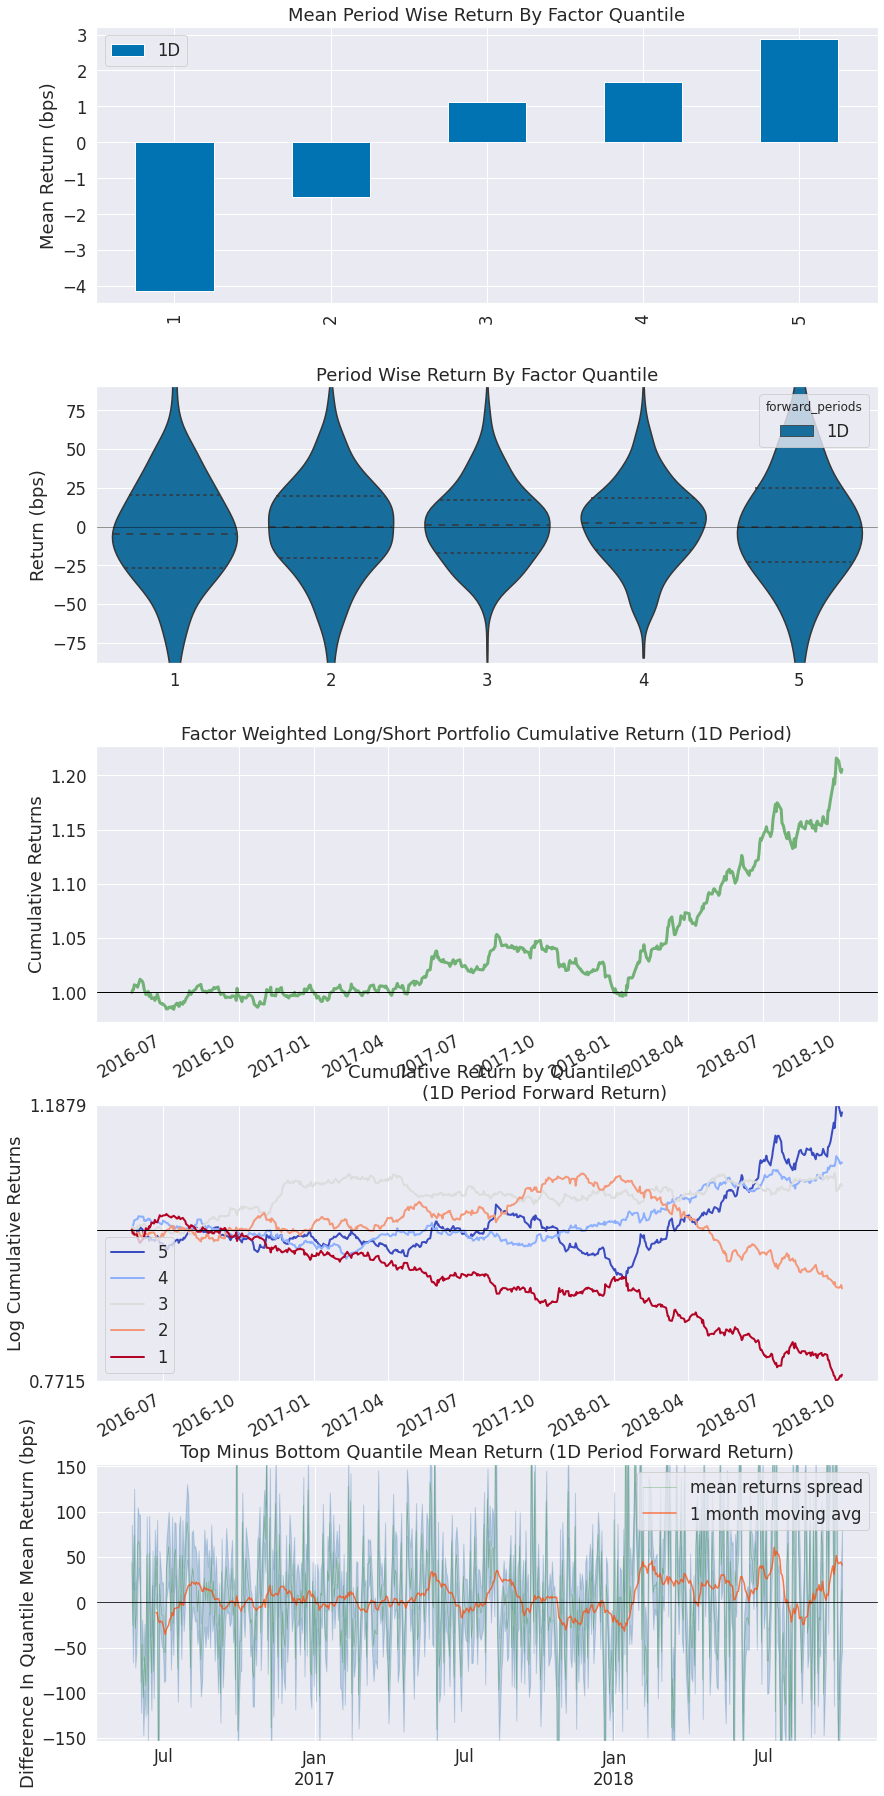

Information Analysis


1D
IC Mean           0.038
IC Std.           0.136
Risk-Adjusted IC  0.284
t-stat(IC)        6.874
p-value(IC)       0.000
IC Skew           0.202
IC Kurtosis       0.058

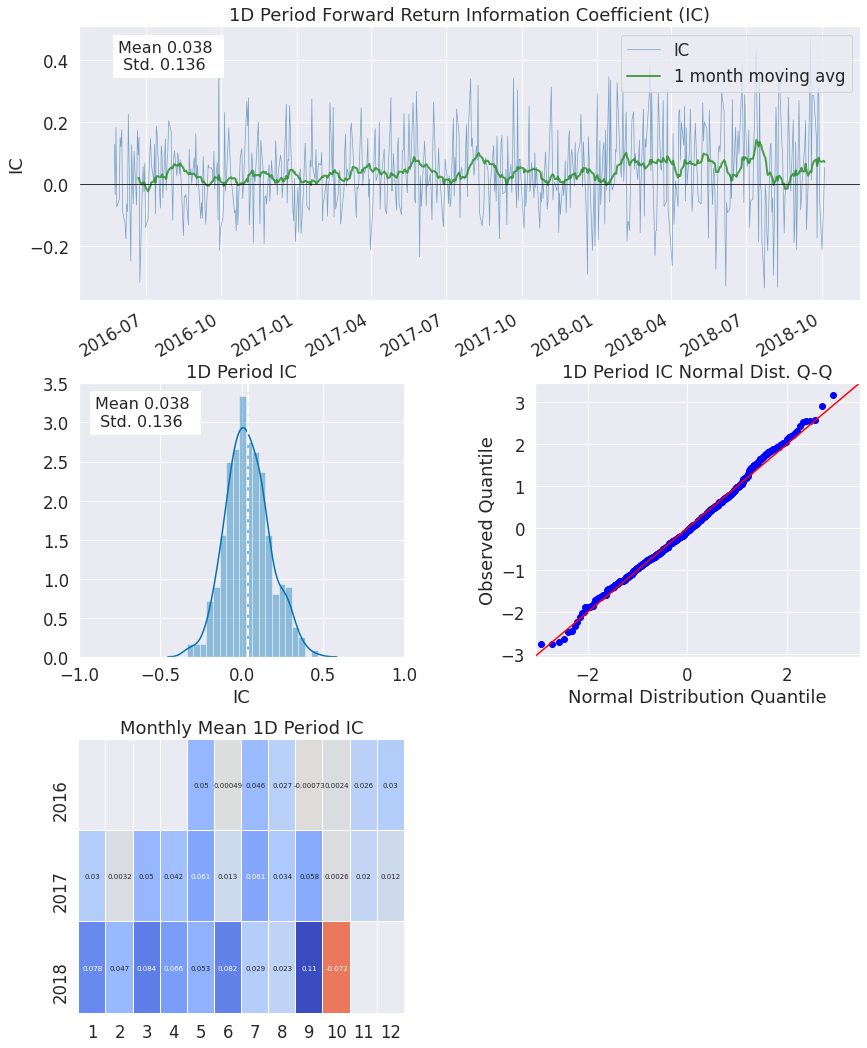

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.115
Quantile 2 Mean Turnover   0.234
Quantile 3 Mean Turnover   0.239
Quantile 4 Mean Turnover   0.191
Quantile 5 Mean Turnover   0.073

1D
Mean Factor Rank Autocorrelation  0.979

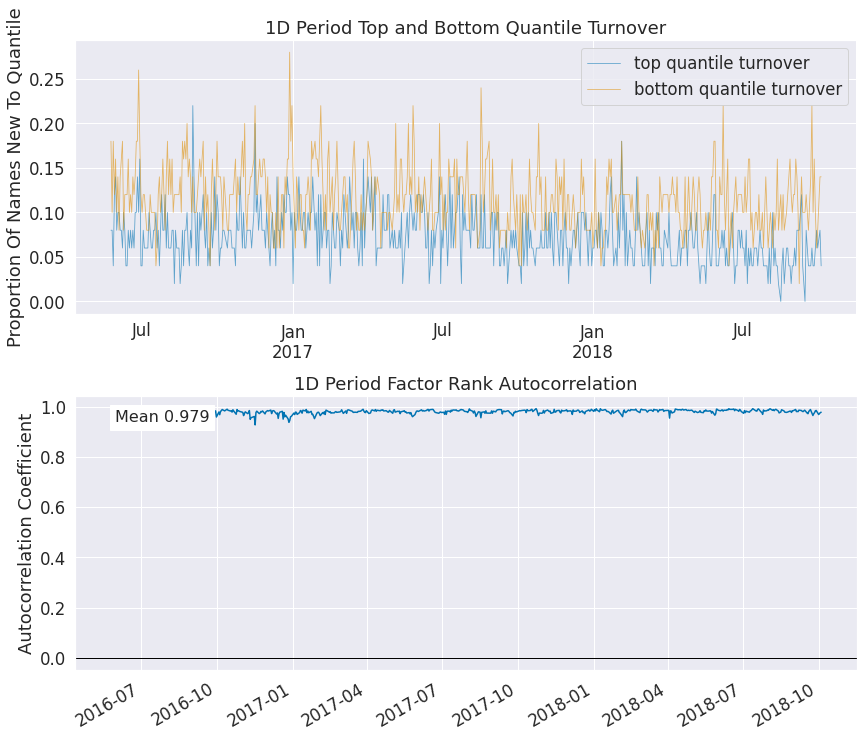


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    0.77
Momentum_1YR                              1.20
Overnight_Sentiment_Smoothed              0.35
time_beta                                 0.47
time_gamma                                0.36
AI_Alpha                                  1.62
dtype: float64


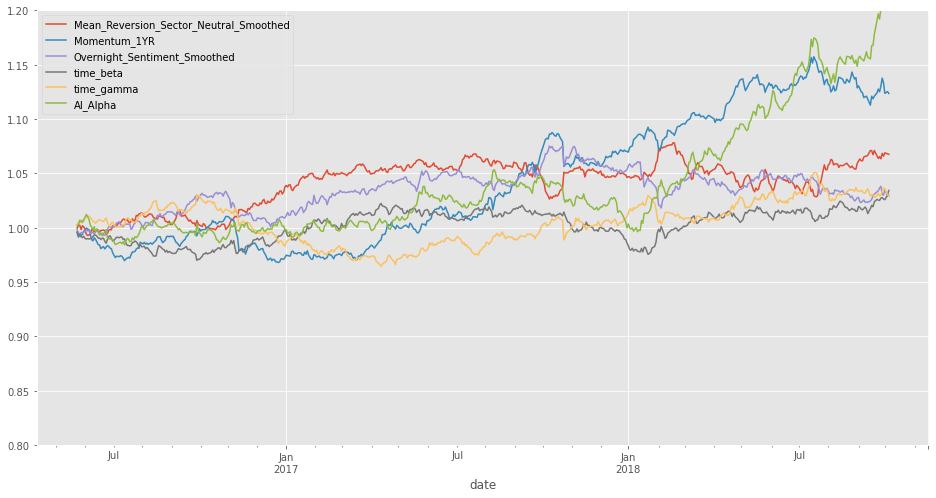

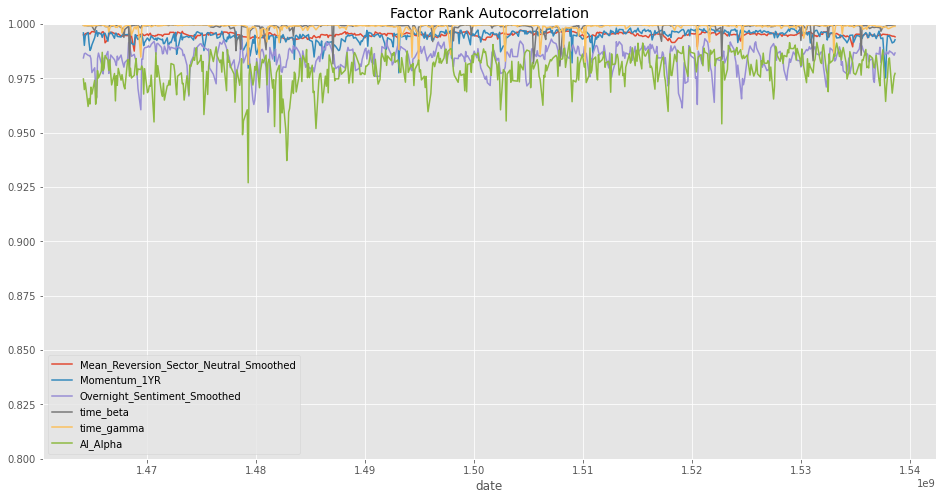

In [25]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.042714 -0.020219 -0.028276  0.003991   9800     20.0
2               -0.025552 -0.012400 -0.018809  0.002652   9800     20.0
3               -0.017915 -0.002553 -0.010699  0.003041   9800     20.0
4               -0.010260  0.011313 -0.000565  0.004474   9800     20.0
5               -0.000295  0.041997  0.016174  0.008660   9800     20.0

Returns Analysis


1D
Ann. alpha                                     0.066
beta                                          -0.331
Mean Period Wise Return Top Quantile (bps)     2.329
Mean Period Wise Return Bottom Quantile (bps) -5.037
Mean Period Wise Spread (bps)                  7.366

<Figure size 1152x576 with 0 Axes>

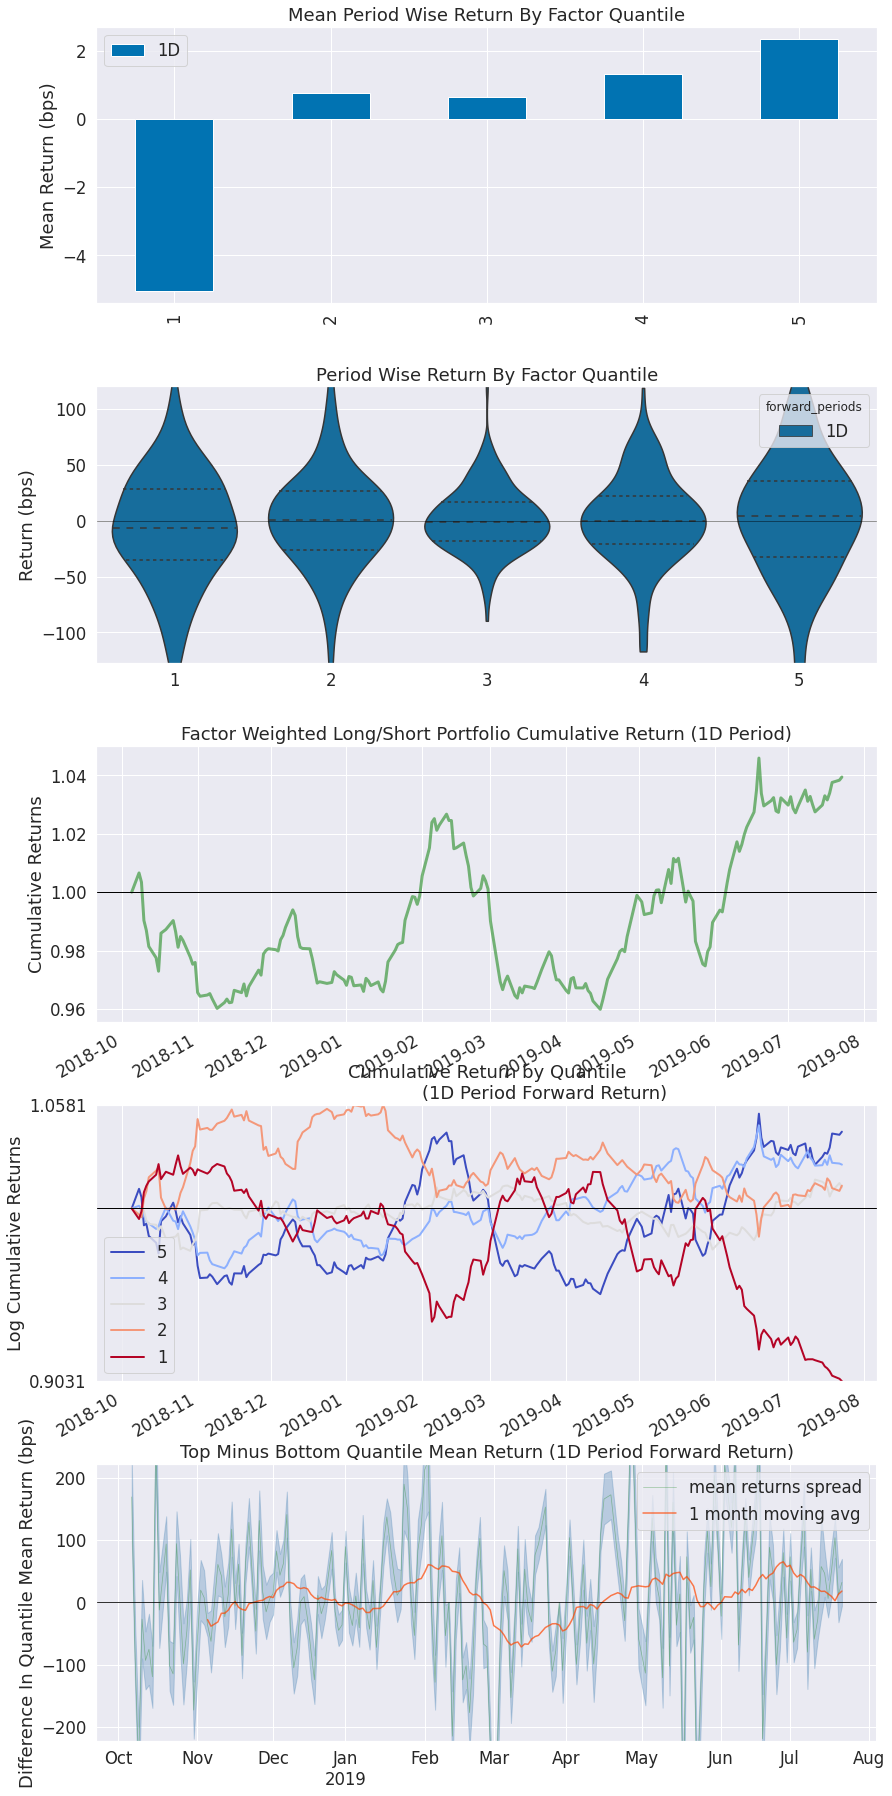

Information Analysis


1D
IC Mean           0.040
IC Std.           0.179
Risk-Adjusted IC  0.223
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

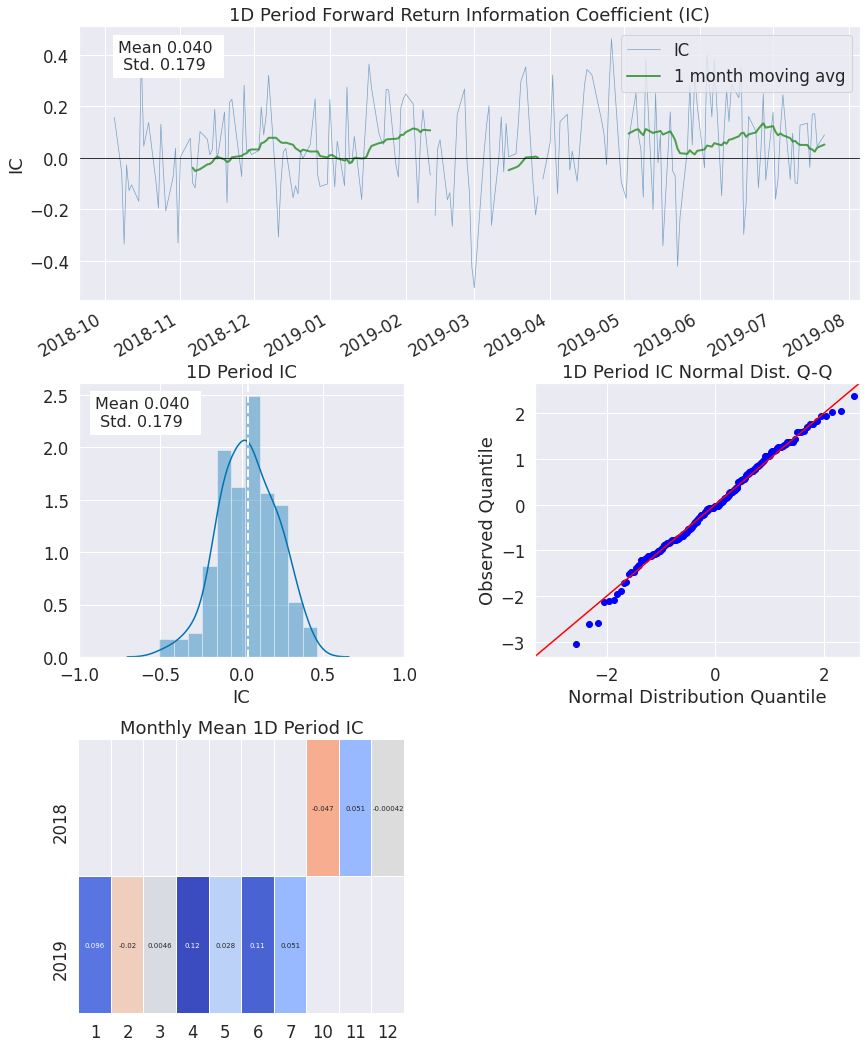

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.110
Quantile 2 Mean Turnover   0.231
Quantile 3 Mean Turnover   0.233
Quantile 4 Mean Turnover   0.175
Quantile 5 Mean Turnover   0.066

1D
Mean Factor Rank Autocorrelation  0.981

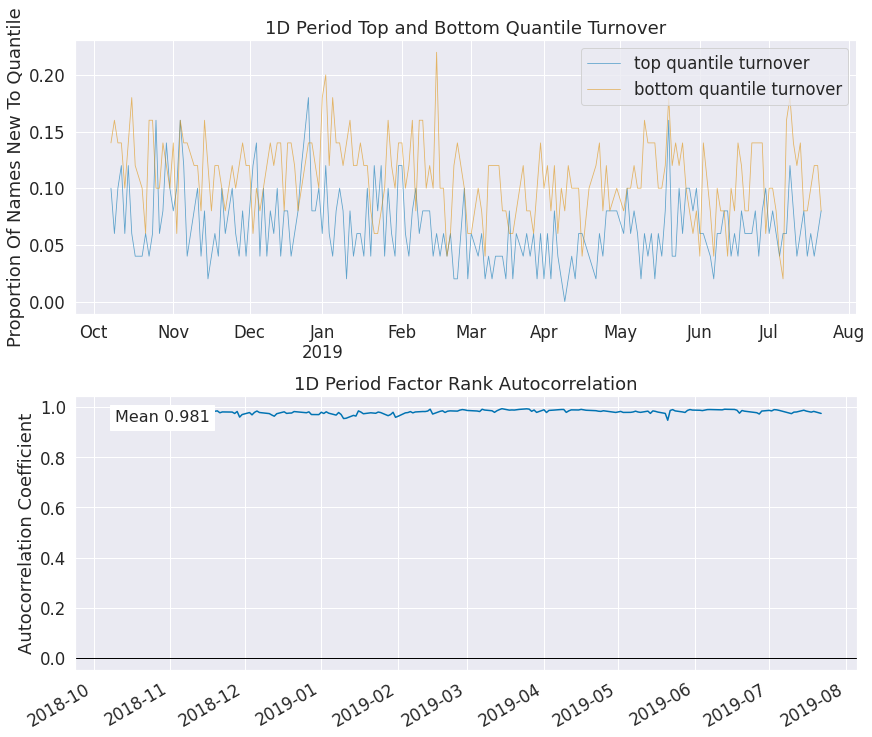


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    1.64
Momentum_1YR                              0.92
Overnight_Sentiment_Smoothed             -2.88
time_beta                                -1.27
time_gamma                                2.20
AI_Alpha                                  0.68
dtype: float64


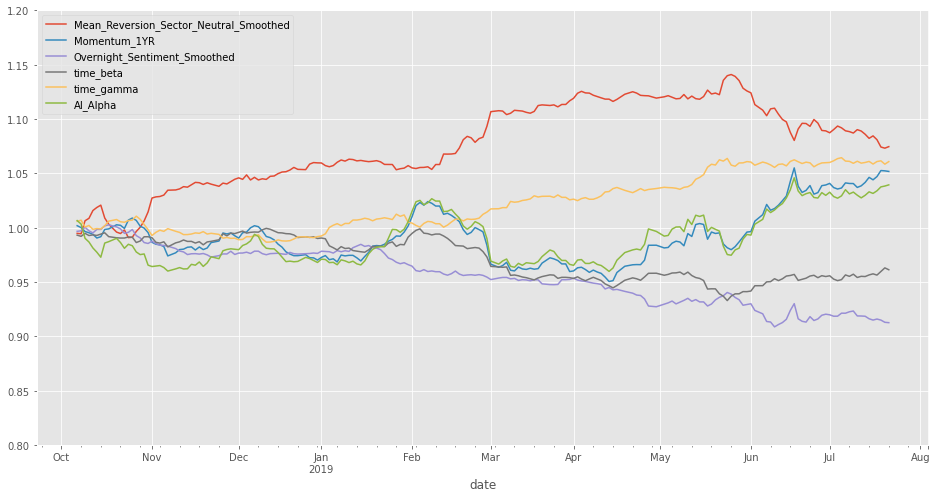

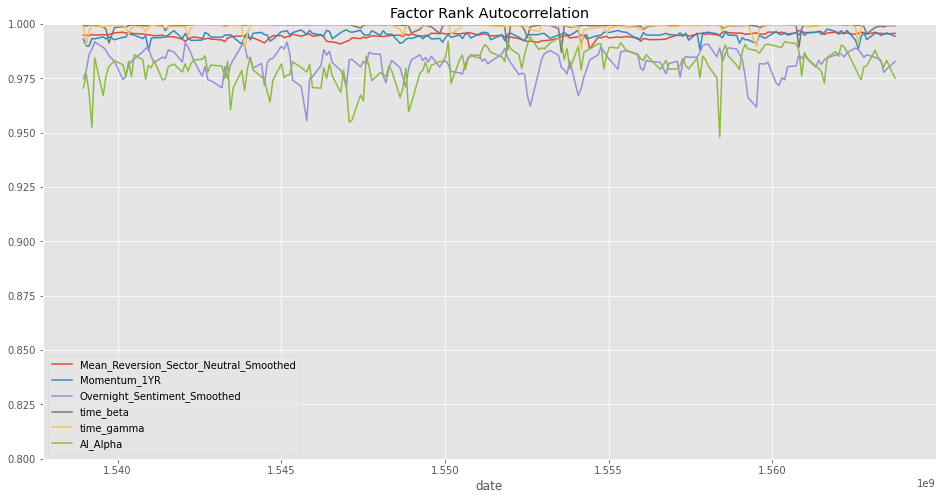

In [26]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [27]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None)

### Results
#### Accuracy

In [28]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.5197006802721088, oob: 0.5292857142857142, valid: 0.5166481136697698


#### Train

Cleaning Data...

Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.061429 -0.012165 -0.028773  0.007602  29350     20.0
2               -0.028643 -0.000873 -0.014427  0.004664  29350     20.0
3               -0.017357  0.007757 -0.003498  0.004255  29350     20.0
4               -0.006105  0.022279  0.008616  0.004770  29350     20.0
5                0.005562  0.054236  0.026641  0.008547  29350     20.0

Returns Analysis


1D
Ann. alpha                                     0.098
beta                                          -0.232
Mean Period Wise Return Top Quantile (bps)     3.155
Mean Period Wise Return Bottom Quantile (bps) -3.203
Mean Period Wise Spread (bps)                  6.358

<Figure size 1152x576 with 0 Axes>

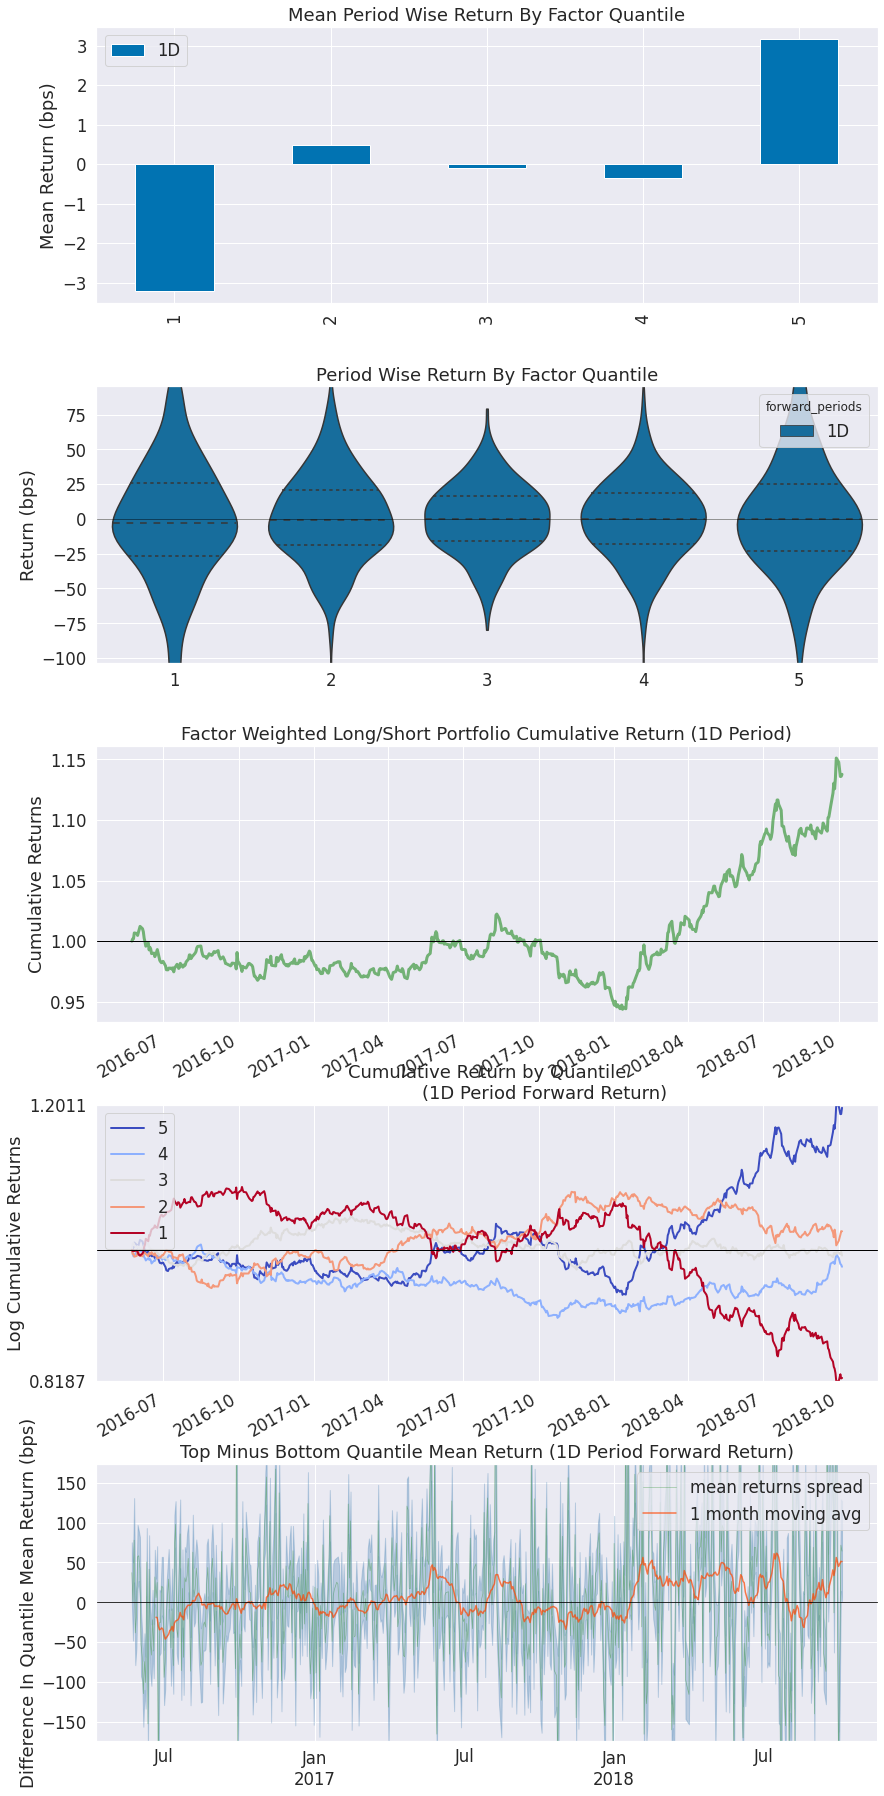

Information Analysis


1D
IC Mean           0.038
IC Std.           0.147
Risk-Adjusted IC  0.259
t-stat(IC)        6.277
p-value(IC)       0.000
IC Skew           0.202
IC Kurtosis      -0.000

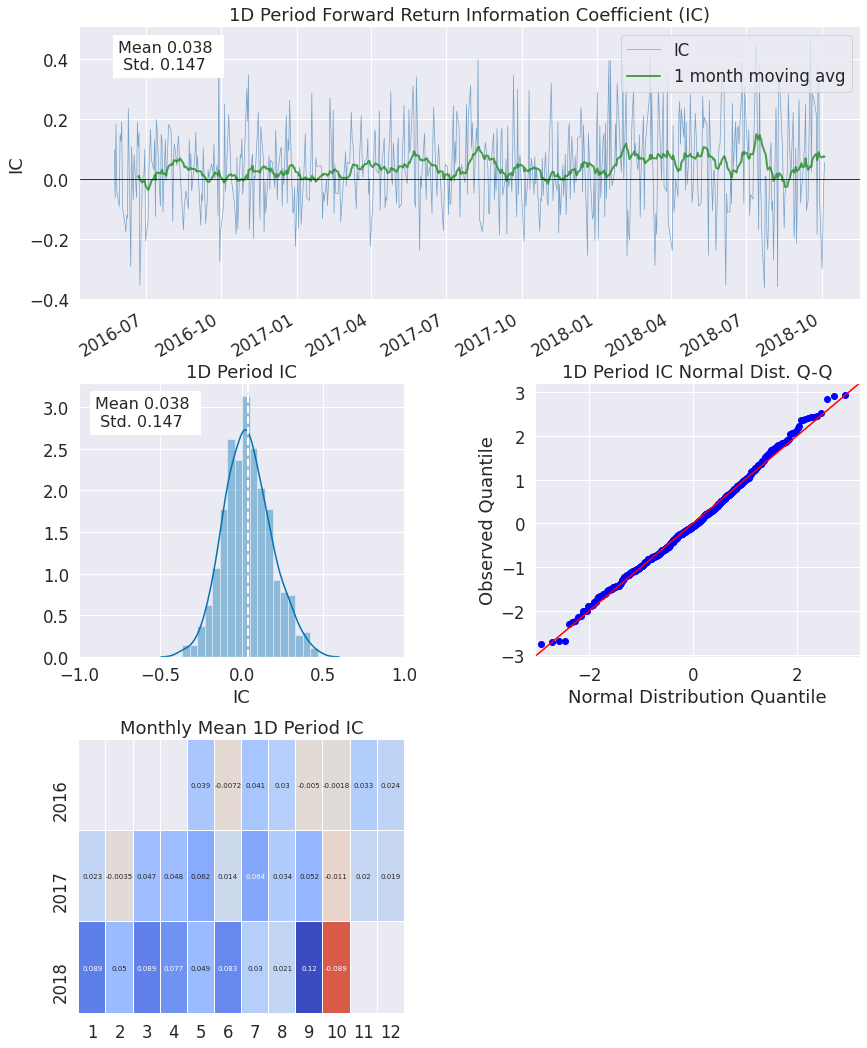

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.101
Quantile 2 Mean Turnover   0.212
Quantile 3 Mean Turnover   0.219
Quantile 4 Mean Turnover   0.177
Quantile 5 Mean Turnover   0.072

1D
Mean Factor Rank Autocorrelation  0.984

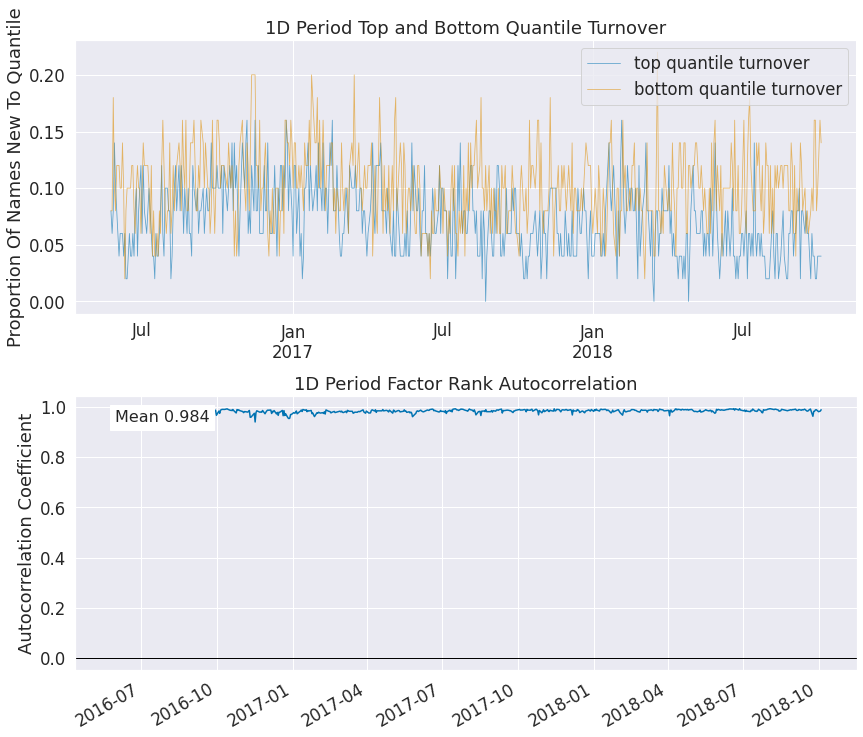


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    0.77
Momentum_1YR                              1.20
Overnight_Sentiment_Smoothed              0.35
time_beta                                 0.47
time_gamma                                0.36
AI_Alpha                                  1.02
dtype: float64


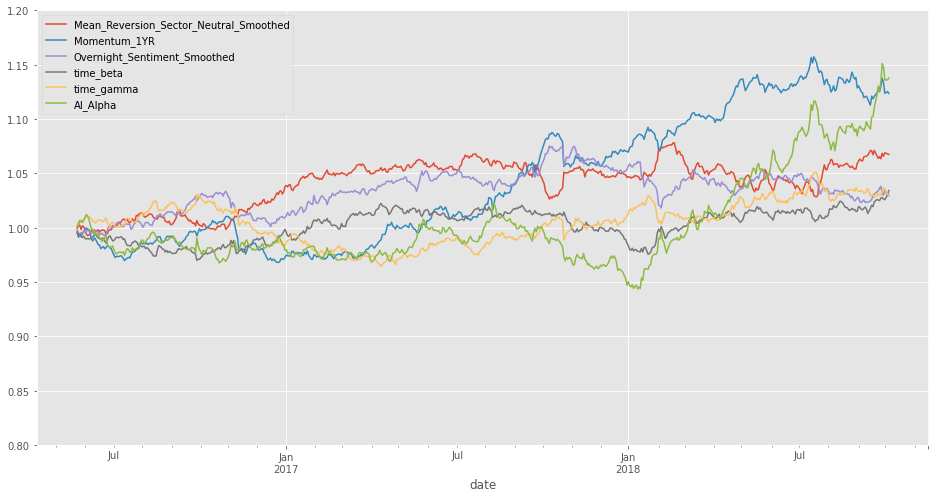

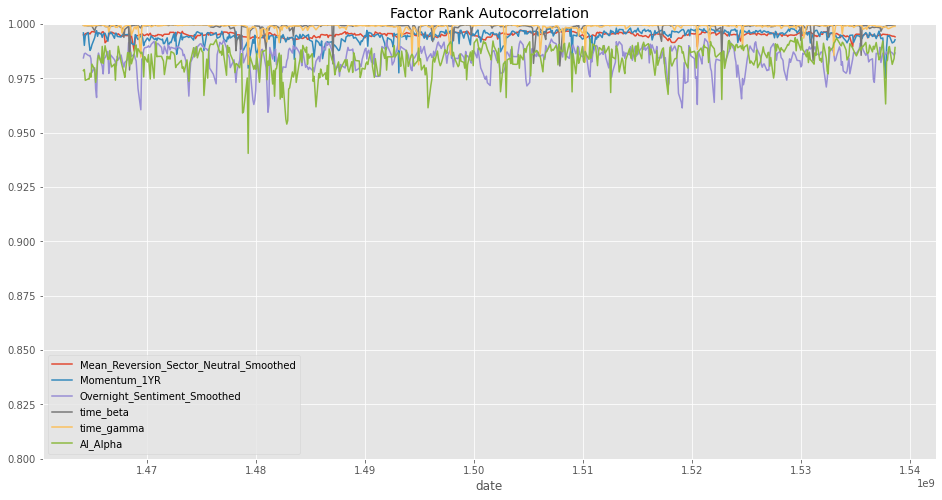

In [29]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.9% entries from factor data: 1.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.060737 -0.021109 -0.035564  0.007571   9800     20.0
2               -0.034364 -0.007304 -0.019799  0.004540   9800     20.0
3               -0.018791  0.003194 -0.007402  0.004454   9800     20.0
4               -0.006795  0.021735  0.005892  0.005524   9800     20.0
5                0.006352  0.054834  0.025678  0.009571   9800     20.0

Returns Analysis


1D
Ann. alpha                                      0.157
beta                                           -0.353
Mean Period Wise Return Top Quantile (bps)      5.568
Mean Period Wise Return Bottom Quantile (bps) -11.395
Mean Period Wise Spread (bps)                  16.963

<Figure size 1152x576 with 0 Axes>

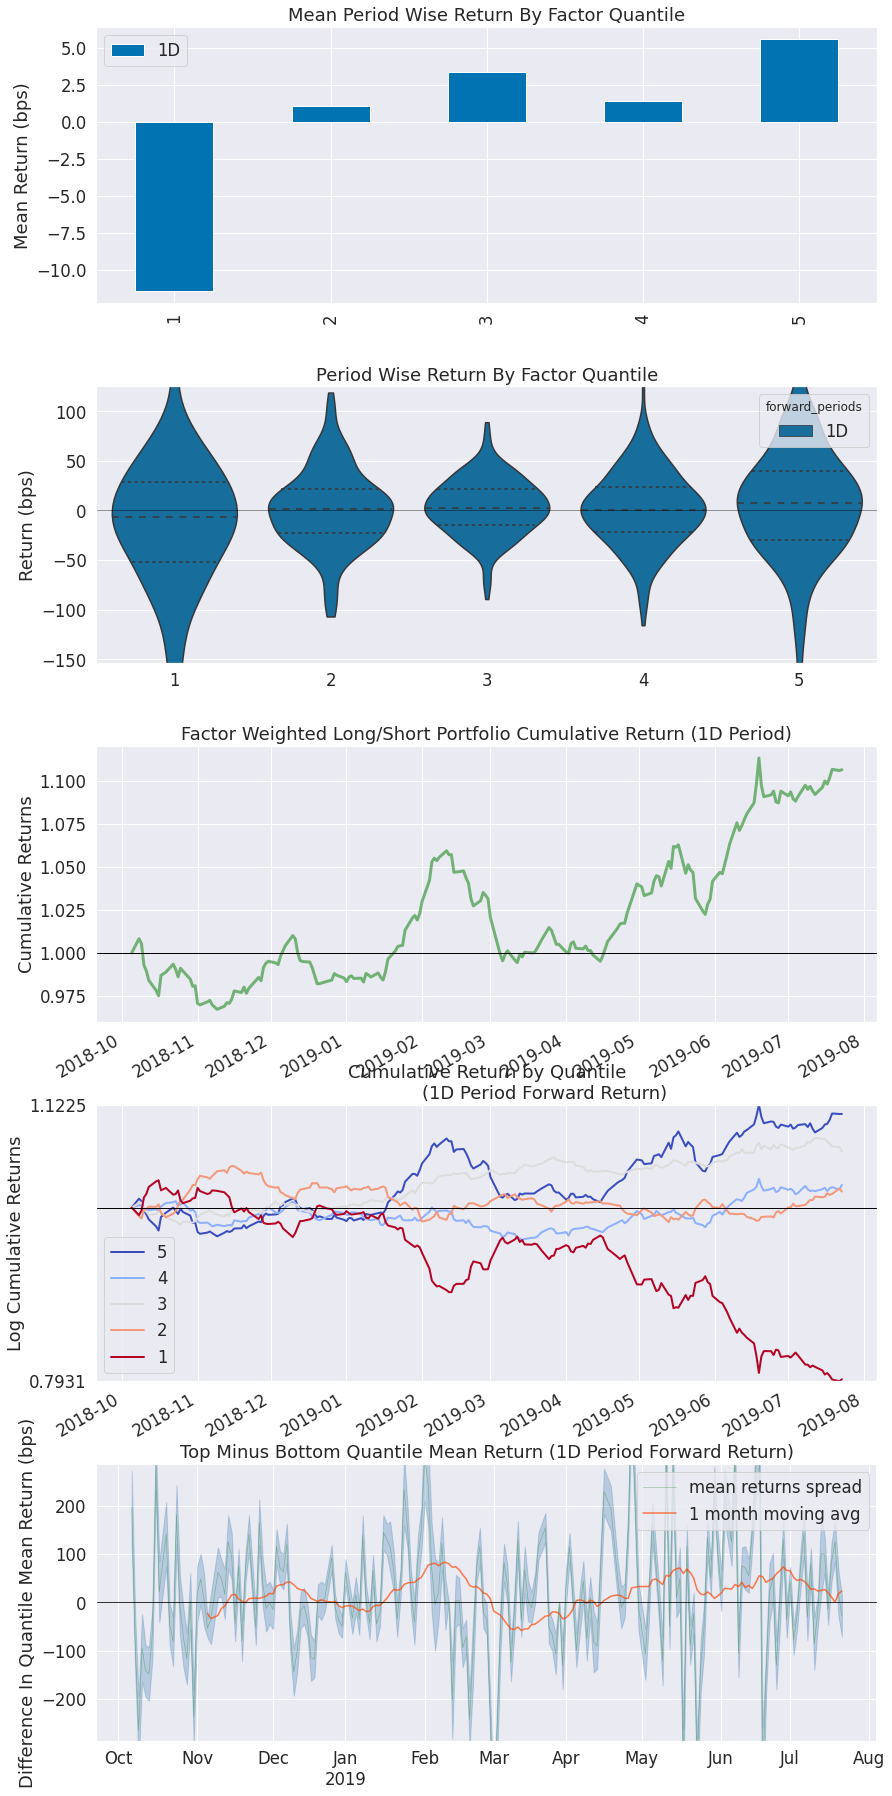

Information Analysis


1D
IC Mean           0.054
IC Std.           0.185
Risk-Adjusted IC  0.293
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

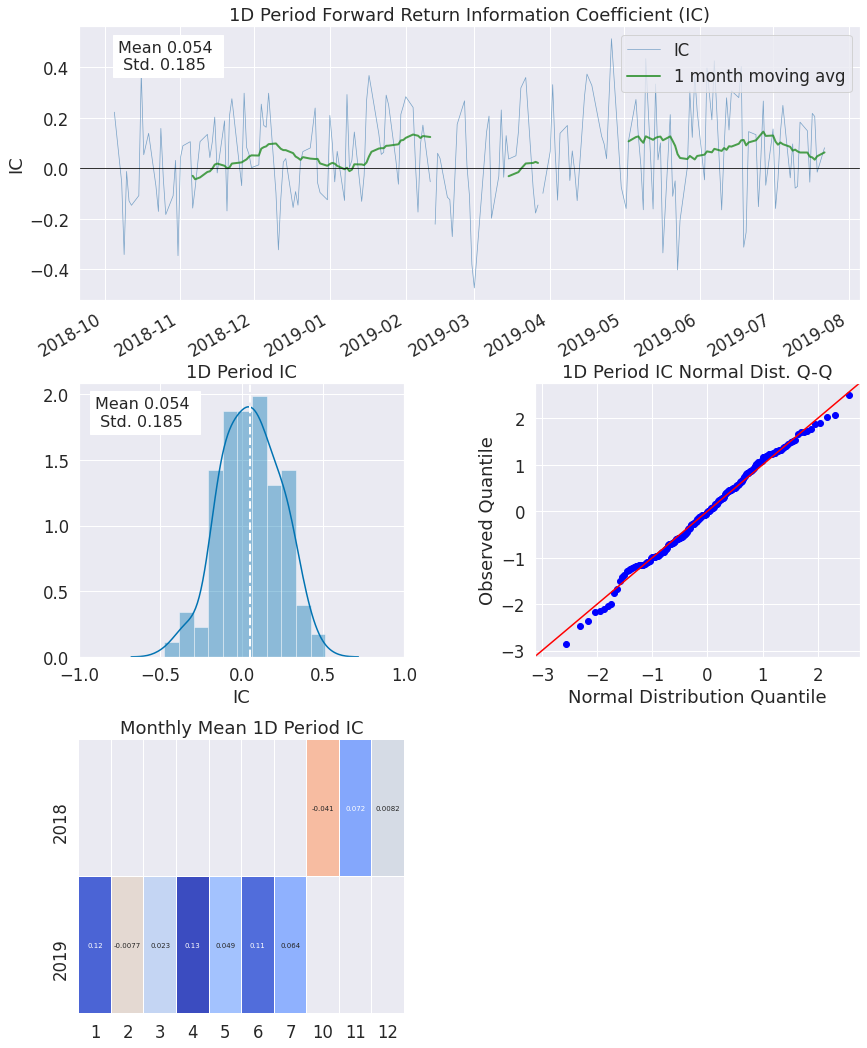

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.087
Quantile 2 Mean Turnover   0.184
Quantile 3 Mean Turnover   0.196
Quantile 4 Mean Turnover   0.166
Quantile 5 Mean Turnover   0.068

1D
Mean Factor Rank Autocorrelation  0.987

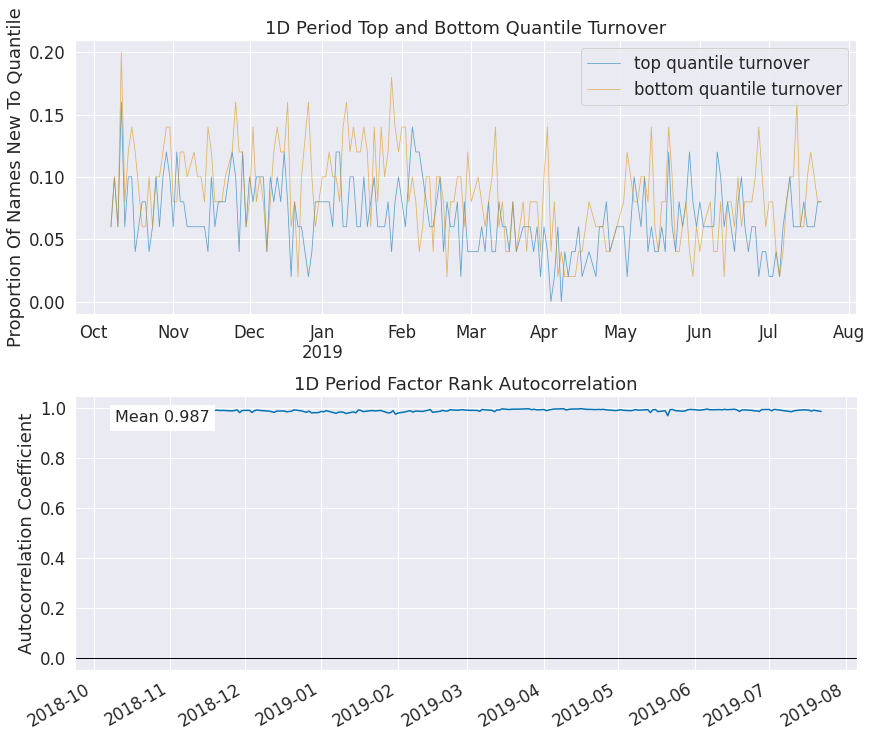


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    1.64
Momentum_1YR                              0.92
Overnight_Sentiment_Smoothed             -2.88
time_beta                                -1.27
time_gamma                                2.20
AI_Alpha                                  1.58
dtype: float64


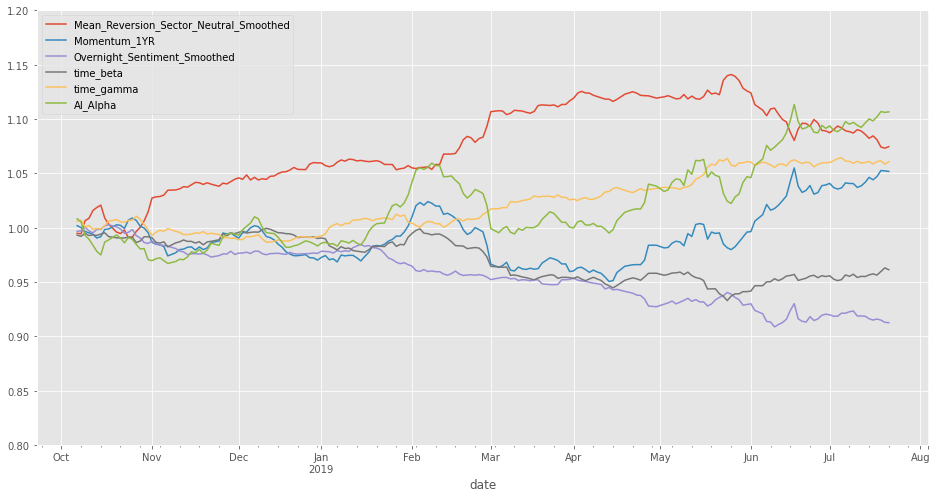

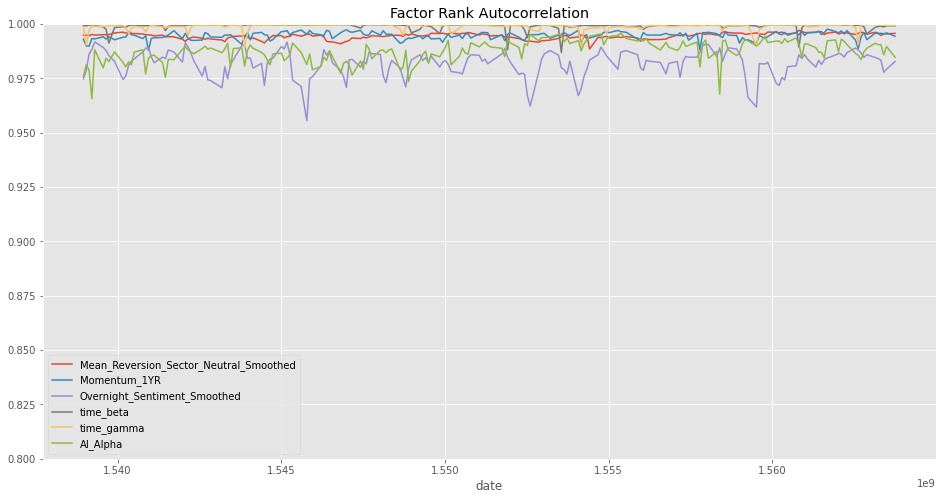

In [30]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

Cleaning Data...

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 3.1% entries from factor data: 3.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 3.1% entries from factor data: 3.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 3.1% entries from factor data: 3.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count  count %
factor_quantile                                                        
1               -0.061207 -0.018235 -0.034292  0.007191   9800     20.0
2               -0.030721 -0.005667 -0.018542  0.004766   9800     20.0
3               -0.022114  0.006657 -0.007175  0.005405   9800     20.0
4               -0.013780  0.022156  0.004679  0.007362   9800     20.0
5               -0.004911  0.049231  0.022610  0.011919   9800     20.0

Returns Analysis


1D
Ann. alpha                                      0.251
beta                                           -0.127
Mean Period Wise Return Top Quantile (bps)      9.638
Mean Period Wise Return Bottom Quantile (bps) -13.871
Mean Period Wise Spread (bps)                  23.510

<Figure size 1152x576 with 0 Axes>

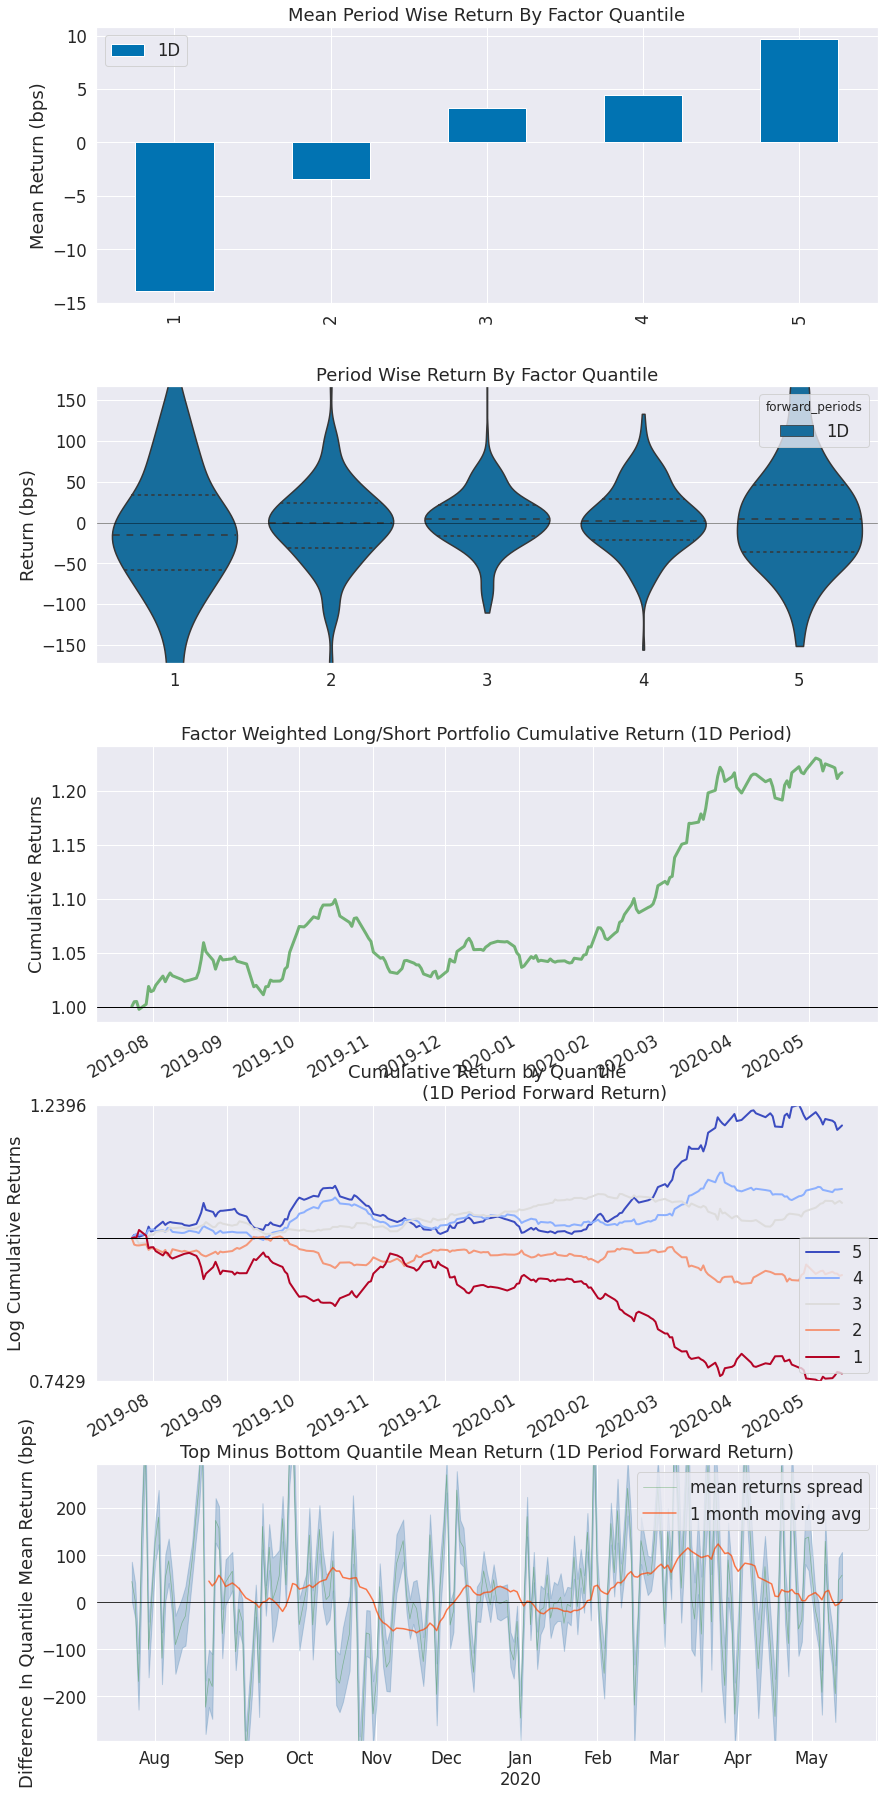

Information Analysis


1D
IC Mean           0.058
IC Std.           0.174
Risk-Adjusted IC  0.333
t-stat(IC)        4.659
p-value(IC)       0.000
IC Skew           0.158
IC Kurtosis      -0.436

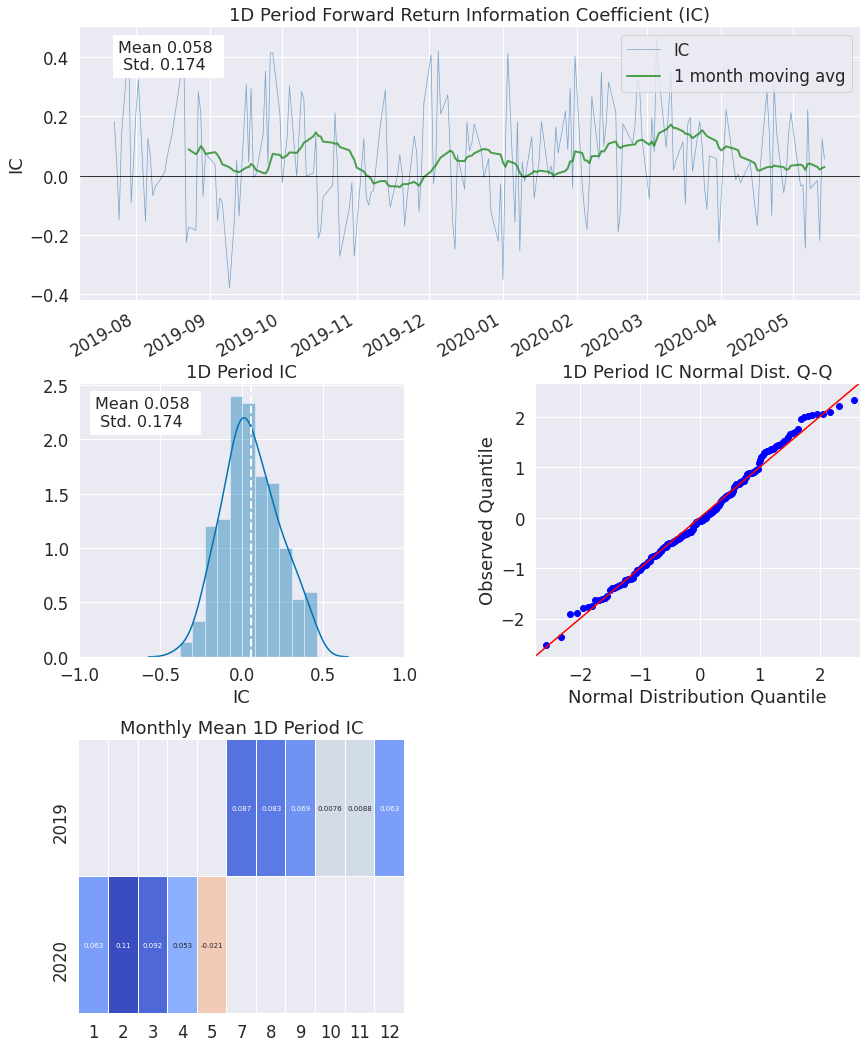

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.087
Quantile 2 Mean Turnover   0.196
Quantile 3 Mean Turnover   0.215
Quantile 4 Mean Turnover   0.175
Quantile 5 Mean Turnover   0.071

1D
Mean Factor Rank Autocorrelation  0.985

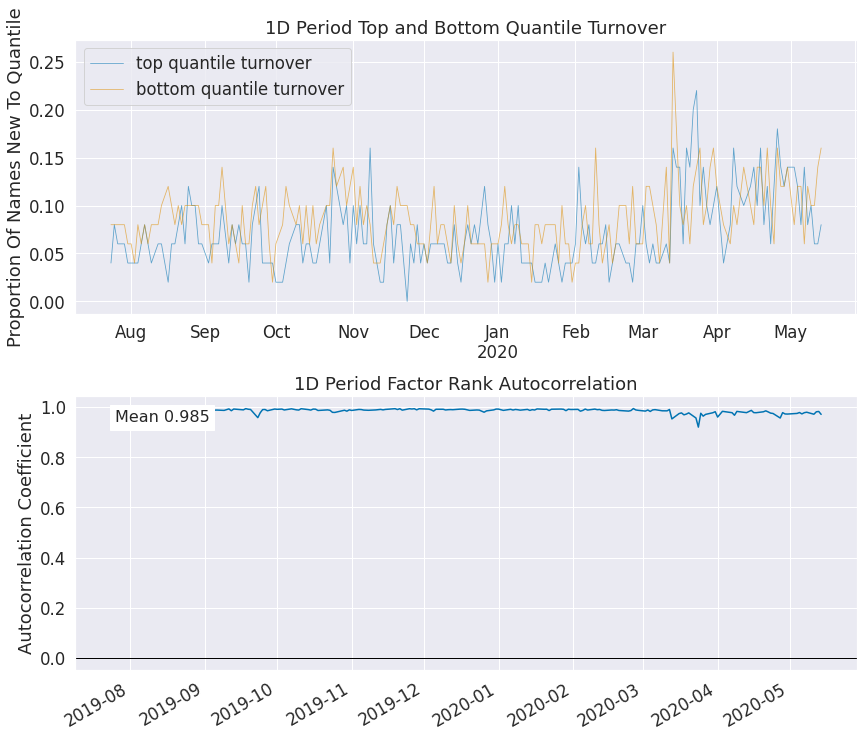


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    0.55
Momentum_1YR                              2.16
Overnight_Sentiment_Smoothed              1.49
time_beta                                 2.56
time_gamma                               -0.21
AI_Alpha                                  2.76
dtype: float64


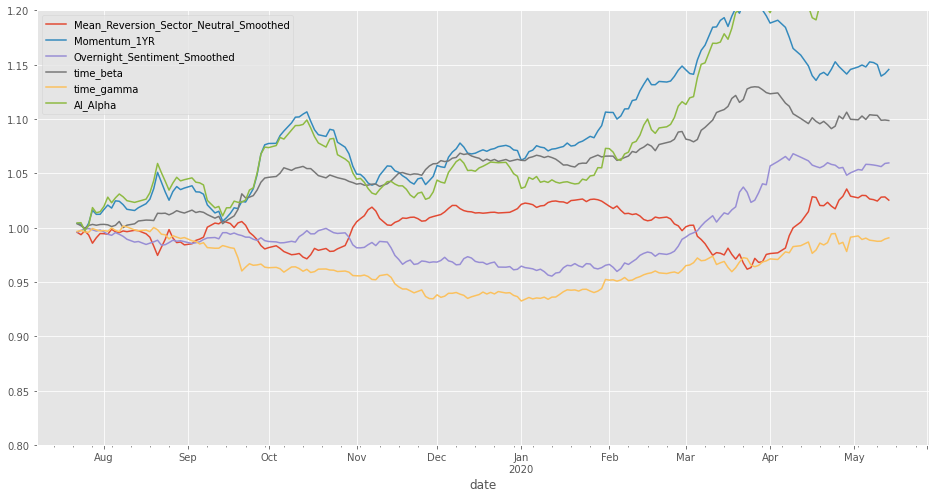

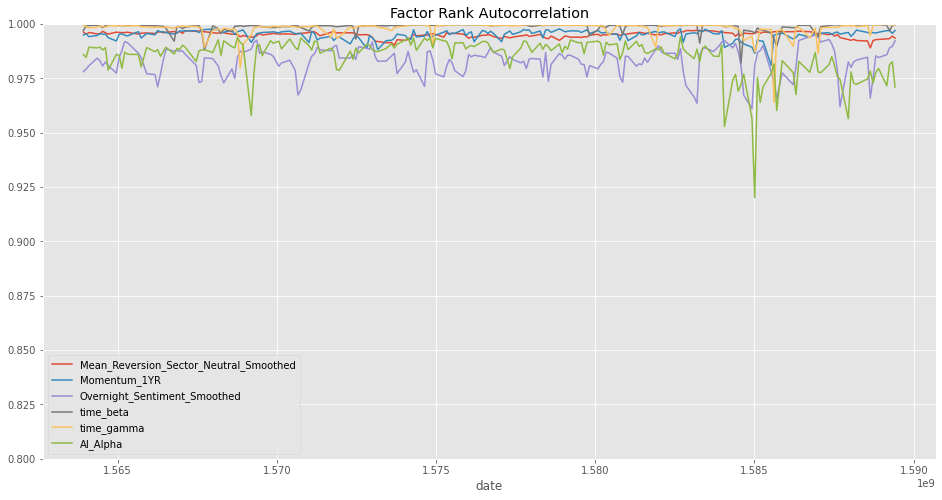

In [31]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

Despite the significant differences between the factor performances in the three sets, the AI APLHA is able to deliver positive performance.

## Getting Predictions Of AI Alpha And Saving

In [32]:
def save_alpha(data,samples,classifier,factors):
    prob_array = [-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    alpha_score_label = 'AI_Alpha'
    factors_with_alpha = samples.copy()
    factors_with_alpha[alpha_score_label] = alpha_score

    return factors_with_alpha[factors + [alpha_score_label]]

In [33]:
factors_with_alpha = save_alpha(all_factors,X_test,clf_nov,factor_names)

# Advanced Portfolio Optimization :

# Statistical Risk Model
It's time to build the risk model. Creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
`fit_pca` function in `risk_model.py` to fit a PCA model to the returns data 

## Factor Betas
`factor_betas` function in `risk_model.py` to get the factor betas from the PCA model.

## Factor Returns
`factor_returns` function in `risk_model.py` to get the factor returns from the PCA model using the returns data.

## Factor Covariance Matrix
`factor_cov_matrix` function in `risk_model.py` to get the factor covariance matrix.

## Idiosyncratic Variance Matrix
`idiosyncratic_var_matrix` function in `risk_model.py` to get the idiosyncratic variance matrix.

## Idiosyncratic Variance Vector
`idiosyncratic_var_vector` function in `risk_model.py` to get the idiosyncratic variance Vector.

## The Risk Model
Using the data we calculated in the risk model,to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

# Optimal Portfolio Constrained by Risk Model
We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.

## Objective and Constraints
Using `AbstractOptimalHoldings` in `portfolio_optimizer.py` as a base class, the `OptimalHoldings` in `portfolio_optimizer.py` class. There's two functions that is implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. This class, `OptimalHoldingsStrictFactor` in `portfolio_optimizer.py`, the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

## Now Optimizing The AI Alpha Factor :
Since we don't want to leak data we are creating a risk model for every day and optimizing the portfolio weights for everyday

In [34]:
def get_optimized_portfolio_weights(all_pricing,factors_with_alpha,start_date,prev_date):
    
    dates = all_pricing.loc[start_date:].index
    
    optimal_portfolio = pd.DataFrame()
    
    for date in tqdm(dates, desc='Optimizing Portfolio', unit='day'):
        
        assets = factors_with_alpha.loc[date].index
        
        alpha_factor = factors_with_alpha['AI_Alpha'].loc[date].values
        
        alpha_dict = {'asset' : assets,'alpha_vector': alpha_factor}
        
        alpha_vector = pd.DataFrame(alpha_dict).set_index('asset')

        returns = all_pricing.loc[:prev_date][assets].tail(253).pct_change()[1:].fillna(0)

        prev_date = date

        risk_model = risk_modelling(returns)

        optimal_weights = OptimalHoldingsStrictFactor(weights_max=0.02,weights_min=-0.02,risk_cap=0.0015,factor_max=0.015,factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])
        
        optimal_weights.columns = [date]
        
        optimal_portfolio = pd.concat([optimal_portfolio,optimal_weights],axis = 1)
        
        
    return optimal_portfolio

In [35]:
start_date = '2019-07-23' # Initial Trading Date Of Alpha
prev_date = '2019-07-22' # Previous Trading Date For Optimization

In [36]:
optimal_portfolio =  get_optimized_portfolio_weights(all_pricing,factors_with_alpha,start_date,prev_date)

Optimizing Portfolio: 100%|██████████| 197/197 [27:25<00:00,  8.35s/day]


In [37]:
optimal_portfolio.to_csv('results/optimal_portfolio_weights.csv')